In [1]:
import math
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from acquire import acquire_zillow, quick_sum, object_values, cont_hist
from prepare import column_nulls, nulls_by_row, handle_missing_values, split_data, delete_outliers, create_features, Min_Max_Scaler, get_counties, standard_data_scale, get_object_cols, get_numeric_cols 
from explore import create_cluster, create_scatter_plot

## Clustering Rough Draft Notebook

### Acquire Zillow

In [2]:
zillow_df = acquire_zillow() ## <-- calling our function documented in acquire_zillow.py

zillow_df.head() ## <-- Looking at out dataframe

typeconstructiontypeid  storytypeid  propertylandusetypeid  \
0                     NaN          NaN                  261.0   
1                     NaN          NaN                  261.0   
2                     NaN          NaN                  261.0   
3                     NaN          NaN                  261.0   
6                     NaN          NaN                  261.0   

   heatingorsystemtypeid  buildingclasstypeid  architecturalstyletypeid  \
0                    NaN                  NaN                       NaN   
1                    NaN                  NaN                       NaN   
2                    NaN                  NaN                       NaN   
3                    2.0                  NaN                       NaN   
6                    2.0                  NaN                       NaN   

   airconditioningtypeid  parcelid  id  logerror  ... taxdelinquencyflag  \
0                    NaN  14297519   0  0.025595  ...               None   
1                    NaN  17052889   1  0.055619  ...               None   
2                    NaN  14186244   2  0.005383  ...               None   
3                    NaN  12177905   3 -0.103410  ...               None   
6                    1.0  12095076   6 -0.001011  ...               None   

   taxdelinquencyyear  censustractandblock  airconditioningdesc  \
0                 NaN         6.059063e+13                 None   
1                 NaN         6.111001e+13                 None   
2                 NaN         6.059022e+13                 None   
3                 NaN         6.037300e+13                 None   
6                 NaN         6.037461e+13              Central   

   architecturalstyledesc  buildingclassdesc  heatingorsystemdesc  \
0                    None               None                 None   
1                    None               None                 None   
2                    None               None                 None   
3                    None               None              Central   
6                    None               None              Central   

         propertylandusedesc  storydesc  typeconstructiondesc  
0  Single Family Residential       None                  None  
1  Single Family Residential       None                  None  
2  Single Family Residential       None                  None  
3  Single Family Residential       None                  None  
6  Single Family Residential       None                  None  

[5 rows x 68 columns]

In [3]:
quick_sum(zillow_df)  ## <-- function to give shape, datatypes, and numerical statistics

Dataframe Shape (rows, columns):
(52320, 68)
-----------------------------------------------

Datatypes of Columns:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52320 entries, 0 to 77579
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        76 non-null     float64
 1   storytypeid                   47 non-null     float64
 2   propertylandusetypeid         52320 non-null  float64
 3   heatingorsystemtypeid         33850 non-null  float64
 4   buildingclasstypeid           0 non-null      float64
 5   architecturalstyletypeid      70 non-null     float64
 6   airconditioningtypeid         13615 non-null  float64
 7   parcelid                      52320 non-null  int64  
 8   id                            52320 non-null  int64  
 9   logerror                      52320 non-null  float64
 10  transactiondate               52320 non-null  object 
 11  bas

In [4]:
## dropping columns with 0 non null values right away based on the .info printout
null_cols = ['buildingclassdesc', 'finishedsquarefeet13', 
             'finishedsquarefeet15', 'buildingclasstypeid']

zillow_df = zillow_df.drop(columns = null_cols) ## <-- dropping those pesky columns

zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52320 entries, 0 to 77579
Data columns (total 64 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        76 non-null     float64
 1   storytypeid                   47 non-null     float64
 2   propertylandusetypeid         52320 non-null  float64
 3   heatingorsystemtypeid         33850 non-null  float64
 4   architecturalstyletypeid      70 non-null     float64
 5   airconditioningtypeid         13615 non-null  float64
 6   parcelid                      52320 non-null  int64  
 7   id                            52320 non-null  int64  
 8   logerror                      52320 non-null  float64
 9   transactiondate               52320 non-null  object 
 10  basementsqft                  47 non-null     float64
 11  bathroomcnt                   52320 non-null  float64
 12  bedroomcnt                    52320 non-null  float64
 13  b

In [5]:
object_values(zillow_df)  ## <-- function that lists object columns's value counts

transactiondate
2017-06-30    809
2017-04-28    614
2017-05-31    565
2017-07-28    546
2017-08-31    528
             ... 
2017-09-25      1
2017-08-12      1
2017-06-03      1
2017-09-09      1
2017-05-07      1
Name: transactiondate, Length: 258, dtype: int64
-----------------------------------------------

propertycountylandusecode
0100    26714
122     13045
0101     6399
1111     3353
1        1066
1110     1024
0104      367
010G       93
0103       91
0108       57
010M       52
0109       18
1112        8
0110        6
0113        6
0141        4
0105        3
0102        3
0130        2
010V        2
0111        2
0133        1
010L        1
0131        1
0115        1
0114        1
Name: propertycountylandusecode, dtype: int64
-----------------------------------------------

propertyzoningdesc
LAR1          6480
LARS          1380
LBR1N         1109
SCUR2          712
LARA           611
              ... 
CVM1YY           1
LRR16500         1
LRR7000V         1
LCA125000*   

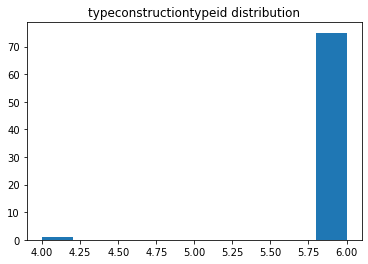

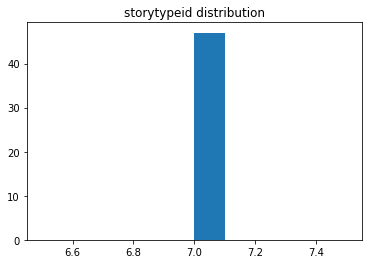

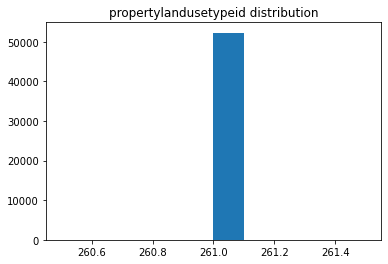

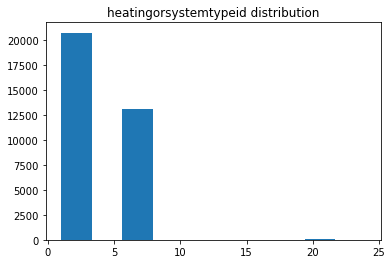

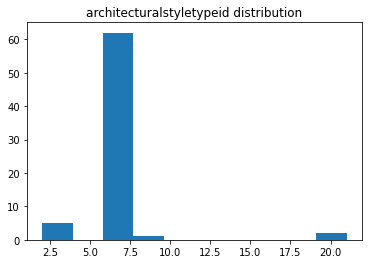

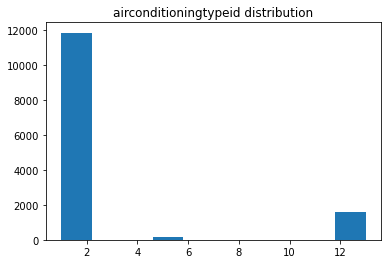

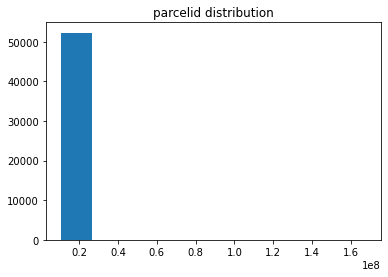

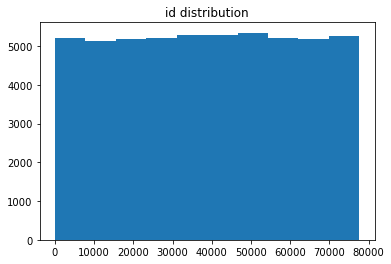

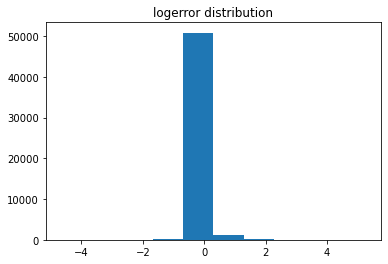

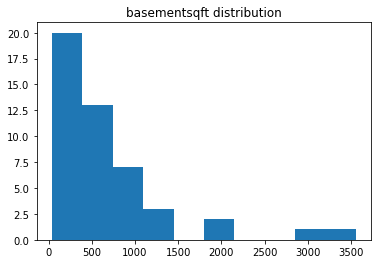

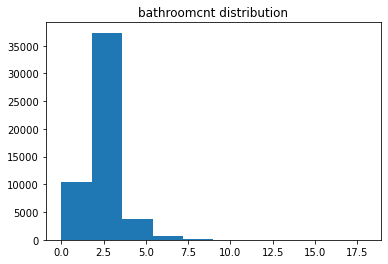

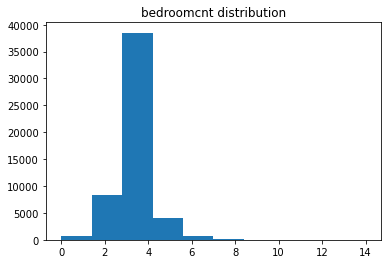

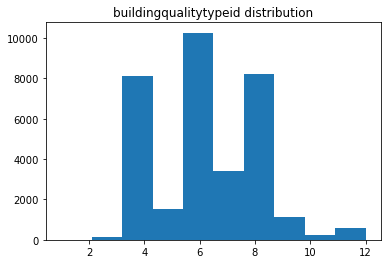

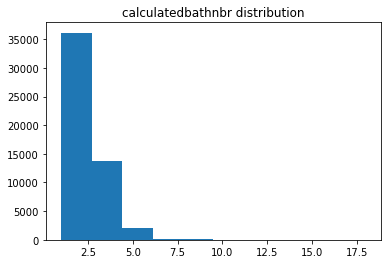

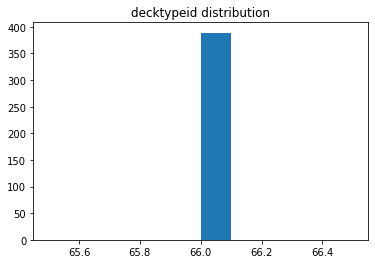

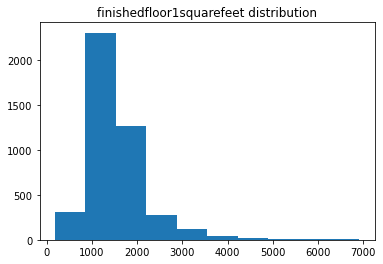

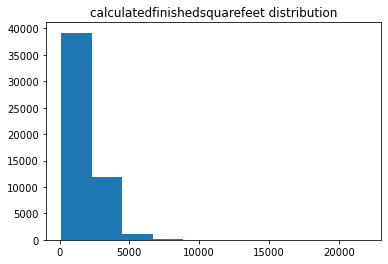

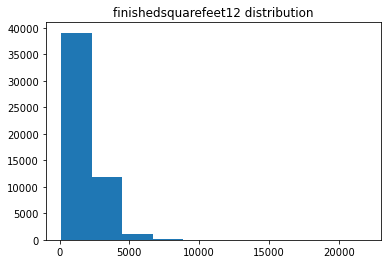

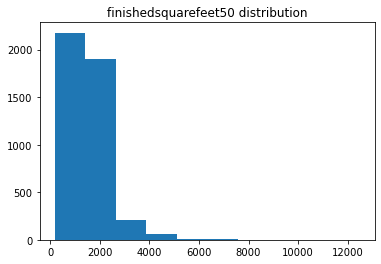

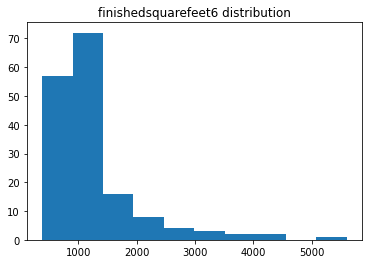

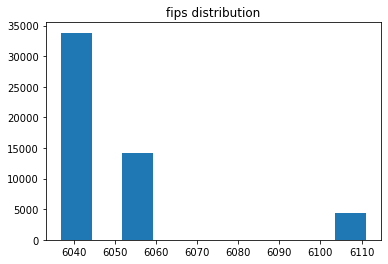

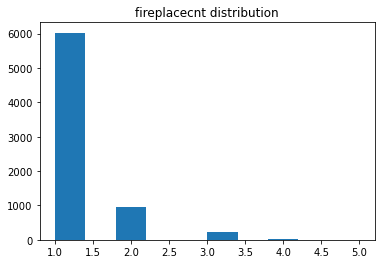

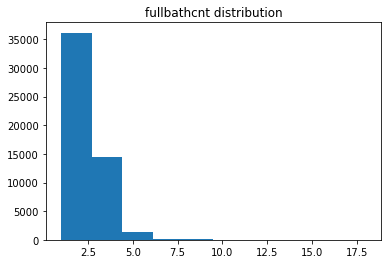

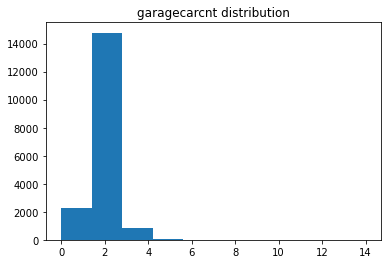

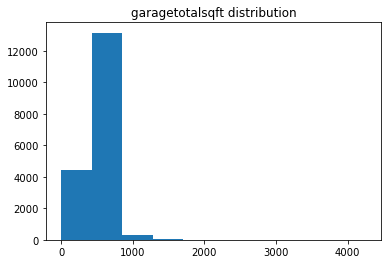

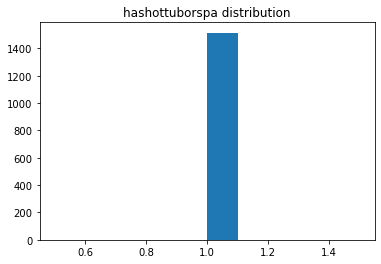

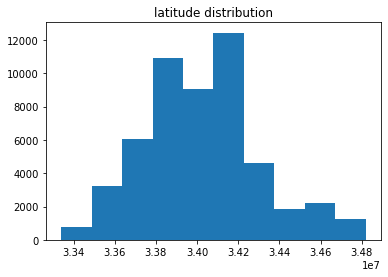

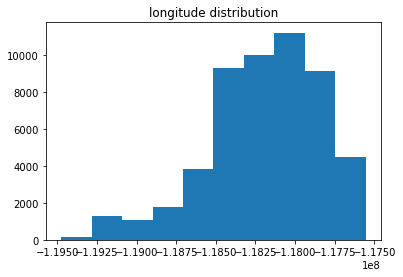

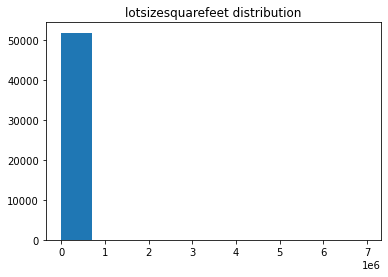

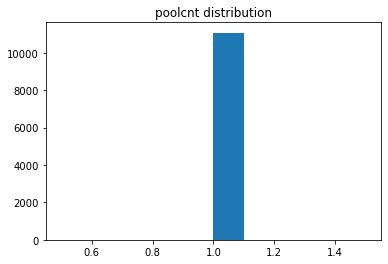

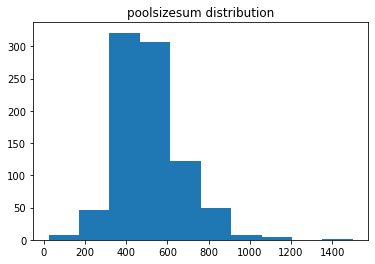

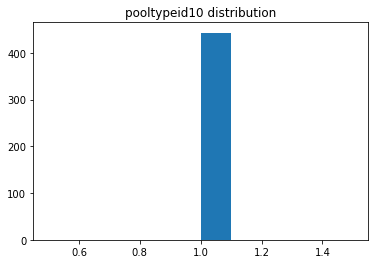

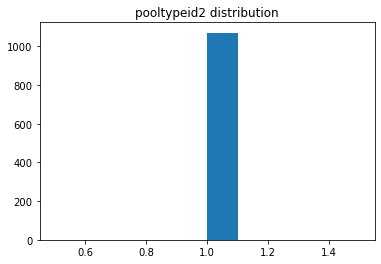

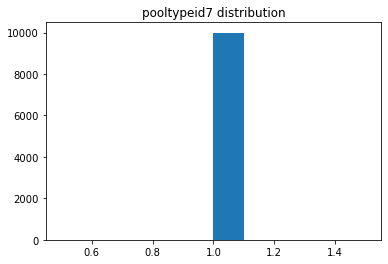

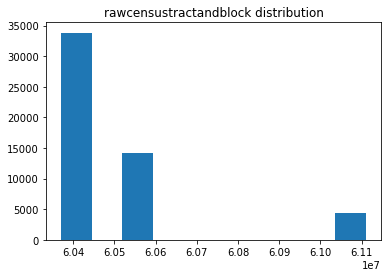

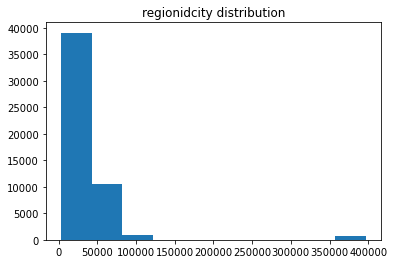

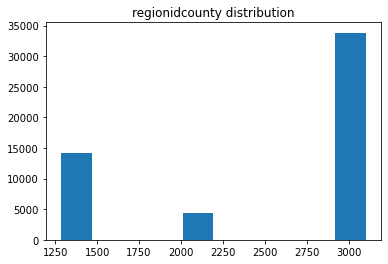

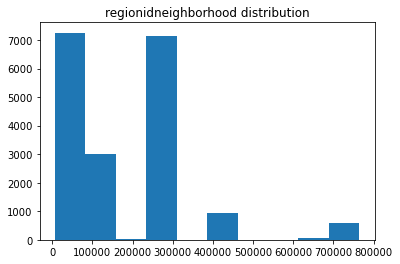

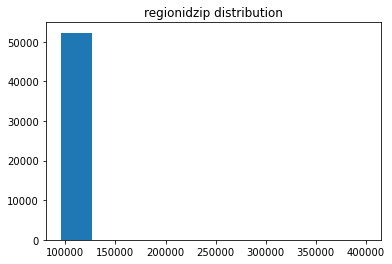

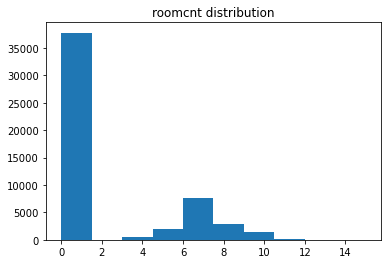

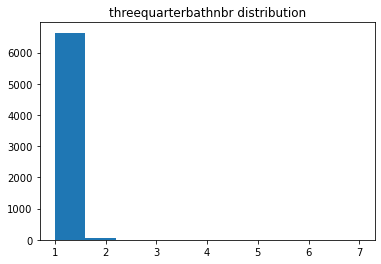

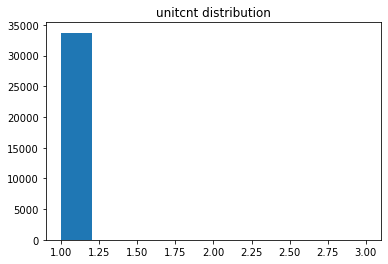

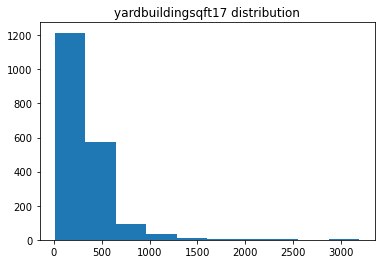

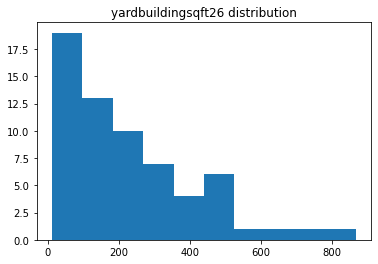

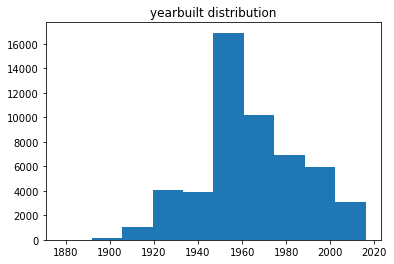

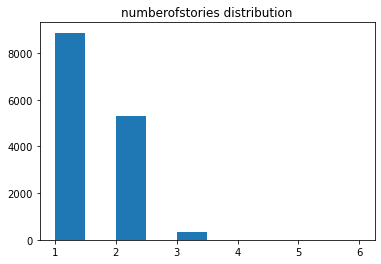

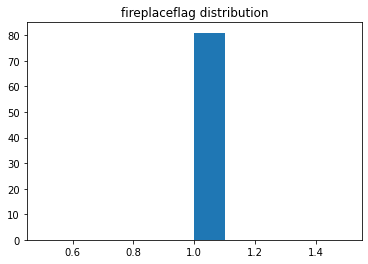

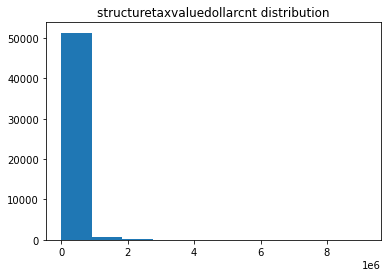

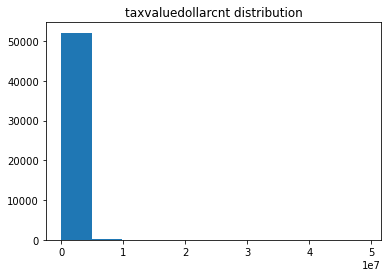

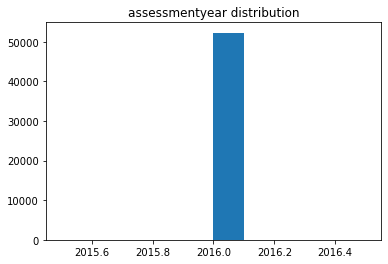

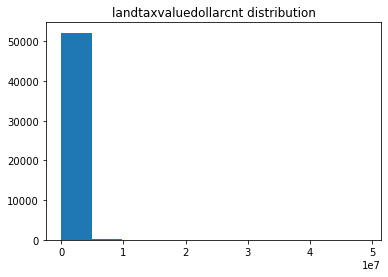

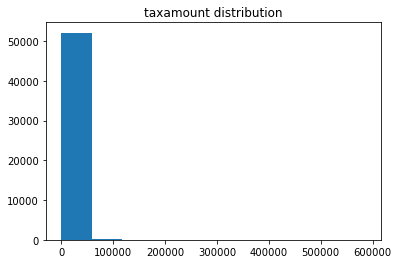

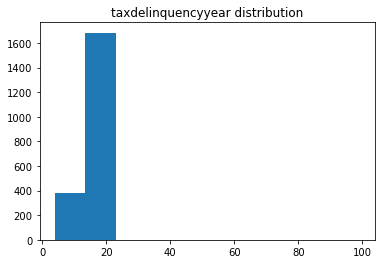

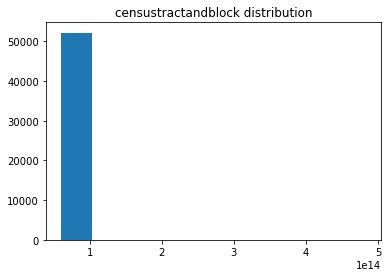

In [6]:
cont_hist(zillow_df)  ## <-- function that looks at the distributions of continuous variables

## Prepare Zillow

In [7]:
column_nulls(zillow_df) ## <-- function that looks null values by column

num_rows_missing  pct_rows_missing
typeconstructiontypeid                   52244          0.998547
storytypeid                              52273          0.999102
propertylandusetypeid                        0          0.000000
heatingorsystemtypeid                    18470          0.353020
architecturalstyletypeid                 52250          0.998662
airconditioningtypeid                    38705          0.739774
parcelid                                     0          0.000000
id                                           0          0.000000
logerror                                     0          0.000000
transactiondate                              0          0.000000
basementsqft                             52273          0.999102
bathroomcnt                                  0          0.000000
bedroomcnt                                   0          0.000000
buildingqualitytypeid                    18665          0.356747
calculatedbathnbr                          135          0.002580
decktypeid                               51931          0.992565
finishedfloor1squarefeet                 47949          0.916456
calculatedfinishedsquarefeet                81          0.001548
finishedsquarefeet12                       246          0.004702
finishedsquarefeet50                     47949          0.916456
finishedsquarefeet6                      52155          0.996846
fips                                         0          0.000000
fireplacecnt                             45087          0.861755
fullbathcnt                                135          0.002580
garagecarcnt                             34336          0.656269
garagetotalsqft                          34336          0.656269
hashottuborspa                           50806          0.971063
latitude                                     0          0.000000
longitude                                    0          0.000000
lotsizesquarefeet                          366          0.006995
poolcnt                                  41243          0.788284
poolsizesum                              51455          0.983467
pooltypeid10                             51877          0.991533
pooltypeid2                              51249          0.979530
pooltypeid7                              42330          0.809060
propertycountylandusecode                    0          0.000000
propertyzoningdesc                       18558          0.354702
rawcensustractandblock                       0          0.000000
regionidcity                              1036          0.019801
regionidcounty                               0          0.000000
regionidneighborhood                     33339          0.637213
regionidzip                                 26          0.000497
roomcnt                                      0          0.000000
threequarterbathnbr                      45603          0.871617
unitcnt                                  18558          0.354702
yardbuildingsqft17                       50385          0.963016
yardbuildingsqft26                       52257          0.998796
yearbuilt                                  114          0.002179
numberofstories                          37788          0.722248
fireplaceflag                            52239          0.998452
structuretaxvaluedollarcnt                  82          0.001567
taxvaluedollarcnt                            1          0.000019
assessmentyear                               0          0.000000
landtaxvaluedollarcnt                        1          0.000019
taxamount                                    4          0.000076
taxdelinquencyflag                       50252          0.960474
taxdelinquencyyear                       50252          0.960474
censustractandblock                        121          0.002313
airconditioningdesc                      38705          0.739774
architecturalstyledesc                   52250          0.998662
heatingorsystemdesc                      18470          0.353020


In [8]:
nulls_by_row(zillow_df) ## <-- function that looks at the nulls by row

num_cols_missing pct_cols_missing  num_rows
0                19          29.6875         2
1                20            31.25        12
2                21          32.8125        11
3                22           34.375        30
4                23          35.9375       177
5                24             37.5       390
6                25          39.0625      2527
7                26           40.625      2199
8                27          42.1875      5989
9                28            43.75      8885
10               29          45.3125     11967
11               30           46.875     11158
12               31          48.4375      3469
13               32             50.0      4138
14               33          51.5625      1020
15               34           53.125       223
16               35          54.6875        29
17               36            56.25        15
18               37          57.8125         6
19               38           59.375         7
20               39          60.9375        10
21               40             62.5        46
22               41          64.0625         6
23               42           65.625         1
24               43          67.1875         1
25               44            68.75         2

In [9]:
handle_missing_values(zillow_df) ## <-- function that handles missing values
## based on .5 threshhold determined from the functions above

propertylandusetypeid  heatingorsystemtypeid  parcelid     id  \
0                      261.0                    NaN  14297519      0   
1                      261.0                    NaN  17052889      1   
2                      261.0                    NaN  14186244      2   
3                      261.0                    2.0  12177905      3   
6                      261.0                    2.0  12095076      6   
...                      ...                    ...       ...    ...   
77575                  261.0                    2.0  11000655  77609   
77576                  261.0                    NaN  17239384  77610   
77577                  261.0                    2.0  12773139  77611   
77578                  261.0                    2.0  12826780  77612   
77579                  261.0                    7.0  13083743  77613   

       logerror transactiondate  bathroomcnt  bedroomcnt  \
0      0.025595      2017-01-01          3.5         4.0   
1      0.055619      2017-01-01          1.0         2.0   
2      0.005383      2017-01-01          2.0         3.0   
3     -0.103410      2017-01-01          3.0         4.0   
6     -0.001011      2017-01-01          3.0         4.0   
...         ...             ...          ...         ...   
77575  0.020615      2017-09-20          2.0         2.0   
77576  0.013209      2017-09-21          2.0         4.0   
77577  0.037129      2017-09-21          1.0         3.0   
77578  0.007204      2017-09-25          2.0         3.0   
77579 -0.197755      2018-05-25          2.0         3.0   

       buildingqualitytypeid  calculatedbathnbr  ...  unitcnt  yearbuilt  \
0                        NaN                3.5  ...      NaN     1998.0   
1                        NaN                1.0  ...      NaN     1967.0   
2                        NaN                2.0  ...      NaN     1962.0   
3                        8.0                3.0  ...      1.0     1970.0   
6                        9.0                3.0  ...      1.0     1950.0   
...                      ...                ...  ...      ...        ...   
77575                    6.0                2.0  ...      1.0     1940.0   
77576                    NaN                2.0  ...      NaN     1964.0   
77577                    4.0                1.0  ...      1.0     1954.0   
77578                    6.0                2.0  ...      1.0     1955.0   
77579                    4.0                2.0  ...      1.0     1960.0   

       structuretaxvaluedollarcnt  taxvaluedollarcnt  assessmentyear  \
0                        485713.0          1023282.0          2016.0   
1                         88000.0           464000.0          2016.0   
2                         85289.0           564778.0          2016.0   
3                        108918.0           145143.0          2016.0   
6                        276684.0           773303.0          2016.0   
...                           ...                ...             ...   
77575                     70917.0           354621.0          2016.0   
77576                     50683.0            67205.0          2016.0   
77577                     32797.0            49546.0          2016.0   
77578                    140000.0           522000.0          2016.0   
77579                     77118.0           259334.0          2016.0   

       landtaxvaluedollarcnt  taxamount censustractandblock  \
0                   537569.0   11013.72        6.059063e+13   
1                   376000.0    5672.48        6.111001e+13   
2                   479489.0    6488.30        6.059022e+13   
3                    36225.0    1777.51        6.037300e+13   
6                   496619.0    9516.26        6.037461e+13   
...                      ...        ...                 ...   
77575               283704.0    4478.43        6.037101e+13   
77576                16522.0    1107.48        6.111008e+13   
77577                16749.0     876.43        6.037434e+13   
77578        

In [10]:
zillow_df.isnull().sum()[zillow_df.isnull().sum()>0] # look at cols with nulls

heatingorsystemtypeid           18470
buildingqualitytypeid           18665
calculatedbathnbr                 135
calculatedfinishedsquarefeet       81
finishedsquarefeet12              246
fullbathcnt                       135
lotsizesquarefeet                 366
propertyzoningdesc              18558
regionidcity                     1036
regionidzip                        26
unitcnt                         18558
yearbuilt                         114
structuretaxvaluedollarcnt         82
taxvaluedollarcnt                   1
landtaxvaluedollarcnt               1
taxamount                           4
censustractandblock               121
heatingorsystemdesc             18470
dtype: int64

In [11]:
# dropping the columns with 18K missing values too much to fill/impute/drop rows
zillow_df = zillow_df.drop(columns = ['heatingorsystemtypeid', 'buildingqualitytypeid',
                                      'propertyzoningdesc', 'unitcnt', 
                                      'heatingorsystemdesc'])

zillow_df.isnull().sum()

propertylandusetypeid              0
parcelid                           0
id                                 0
logerror                           0
transactiondate                    0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr                135
calculatedfinishedsquarefeet      81
finishedsquarefeet12             246
fips                               0
fullbathcnt                      135
latitude                           0
longitude                          0
lotsizesquarefeet                366
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1036
regionidcounty                     0
regionidzip                       26
roomcnt                            0
yearbuilt                        114
structuretaxvaluedollarcnt        82
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          4
c

In [12]:
zillow_df = zillow_df.dropna()  ## <-- drop the nulls for the first run through
zillow_df.shape 

(50560, 29)

In [13]:
zillow_df.isnull().sum() ## <-- making sure the nulls are gone

propertylandusetypeid           0
parcelid                        0
id                              0
logerror                        0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
propertylandusedesc             0
dtype: int64

In [14]:
zillow_df = create_features(zillow_df) ## <-- function to create more features

In [15]:
zillow_df = get_counties(zillow_df) ## <-- function to create a county column based on fips codes

In [16]:
train, validate, test = split_data(zillow_df) ## <-- function to split data into train validate and test

In [17]:
train.shape, validate.shape, test.shape

((28313, 37), (12135, 37), (10112, 37))

In [18]:
train.head()

propertylandusetypeid  parcelid     id  logerror transactiondate  \
38208                  261.0  10966493  38223  0.050380      2017-05-19   
71943                  261.0  10773573  71973  0.031721      2017-08-30   
26640                  261.0  12396711  26653 -0.024260      2017-04-14   
6803                   261.0  12840203   6809  0.153838      2017-01-31   
75193                  261.0  12864189  75227  0.000536      2017-09-08   

       bathroomcnt  bedroomcnt  calculatedbathnbr  \
38208          2.0         4.0                2.0   
71943          1.0         3.0                1.0   
26640          3.0         5.0                3.0   
6803           4.0         5.0                4.0   
75193          2.0         3.0                2.0   

       calculatedfinishedsquarefeet  finishedsquarefeet12  ...  \
38208                        1170.0                1170.0  ...   
71943                         980.0                 980.0  ...   
26640                        2375.0                2375.0  ...   
6803                         3255.0                3255.0  ...   
75193                        1768.0                1768.0  ...   

       censustractandblock        propertylandusedesc   age  age_bin  \
38208         6.037107e+13  Single Family Residential  63.0    0.466   
71943         6.037135e+13  Single Family Residential  66.0    0.466   
26640         6.037502e+13  Single Family Residential  67.0    0.466   
6803          6.037409e+13  Single Family Residential  25.0    0.200   
75193         6.037402e+13  Single Family Residential  53.0    0.400   

        taxrate     acres  acres_bin  sqft_bin  bath_bed_ratio       county  
38208  1.272128  0.138843        0.1       0.2        0.500000  Los Angeles  
71943  1.203759  0.162534        0.2       0.1        0.333333  Los Angeles  
26640  1.294398  0.120202        0.1       0.5        0.600000  Los Angeles  
6803   1.251334  0.245868        0.2       0.7        0.800000  Los Angeles  
75193  1.281451  0.263935        0.3       0.4        0.666667  Los Angeles  

[5 rows x 37 columns]

In [19]:
validate.head()

propertylandusetypeid  parcelid     id  logerror transactiondate  \
59891                  261.0  11415211  59915  0.032461      2017-07-24   
64482                  261.0  10922040  64508 -0.054856      2017-08-08   
29816                  261.0  12854930  29830 -0.040826      2017-04-26   
7155                   261.0  14300843   7161  0.047229      2017-02-01   
5940                   261.0  11321438   5946 -0.006352      2017-01-27   

       bathroomcnt  bedroomcnt  calculatedbathnbr  \
59891          1.0         2.0                1.0   
64482          1.0         2.0                1.0   
29816          2.0         3.0                2.0   
7155           1.0         2.0                1.0   
5940           3.0         4.0                3.0   

       calculatedfinishedsquarefeet  finishedsquarefeet12  ...  \
59891                         781.0                 781.0  ...   
64482                         964.0                 964.0  ...   
29816                        1300.0                1300.0  ...   
7155                          976.0                 976.0  ...   
5940                         3437.0                3437.0  ...   

       censustractandblock        propertylandusedesc   age  age_bin  \
59891         6.037602e+13  Single Family Residential  69.0    0.466   
64482         6.037102e+13  Single Family Residential  81.0    0.600   
29816         6.037403e+13  Single Family Residential  54.0    0.400   
7155          6.059053e+13  Single Family Residential  46.0    0.333   
5940          6.037901e+13  Single Family Residential  11.0    0.133   

        taxrate     acres  acres_bin  sqft_bin  bath_bed_ratio       county  
59891  1.580282  0.135285        0.1       0.0        0.500000  Los Angeles  
64482  1.362495  0.313636        0.3       0.1        0.500000  Los Angeles  
29816  1.225172  0.237741        0.2       0.3        0.666667  Los Angeles  
7155   1.024883  0.118067        0.1       0.1        0.500000       Orange  
5940   1.647290  0.257002        0.3       0.7        0.750000  Los Angeles  

[5 rows x 37 columns]

In [20]:
test.head()

propertylandusetypeid  parcelid     id  logerror transactiondate  \
28464                  261.0  12915644  28478 -0.019285      2017-04-21   
10981                  261.0  14082257  10990 -0.011435      2017-02-21   
42750                  261.0  12401020  42769 -0.071271      2017-06-02   
76900                  261.0  14015161  76934 -0.000844      2017-09-15   
17647                  261.0  12499543  17657 -0.041809      2017-03-16   

       bathroomcnt  bedroomcnt  calculatedbathnbr  \
28464          2.0         3.0                2.0   
10981          2.5         3.0                2.5   
42750          3.0         3.0                3.0   
76900          2.0         3.0                2.0   
17647          2.0         4.0                2.0   

       calculatedfinishedsquarefeet  finishedsquarefeet12  ...  \
28464                        1198.0                1198.0  ...   
10981                        1540.0                1540.0  ...   
42750                        2443.0                2443.0  ...   
76900                        1108.0                1108.0  ...   
17647                        1432.0                1432.0  ...   

       censustractandblock        propertylandusedesc   age  age_bin  \
28464         6.037406e+13  Single Family Residential  59.0    0.400   
10981         6.059099e+13  Single Family Residential  27.0    0.200   
42750         6.037551e+13  Single Family Residential  62.0    0.466   
76900         6.059110e+13  Single Family Residential  61.0    0.466   
17647         6.037572e+13  Single Family Residential  73.0    0.533   

        taxrate     acres  acres_bin  sqft_bin  bath_bed_ratio       county  
28464  1.561176  0.153007        0.2       0.2        0.666667  Los Angeles  
10981  1.148132  0.072314        0.0       0.4        0.833333       Orange  
42750  1.247290  0.225666        0.2       0.5        1.000000  Los Angeles  
76900  1.176414  0.152893        0.2       0.2        0.666667       Orange  
17647  1.224704  0.123691        0.1       0.3        0.500000  Los Angeles  

[5 rows x 37 columns]

### Explore 

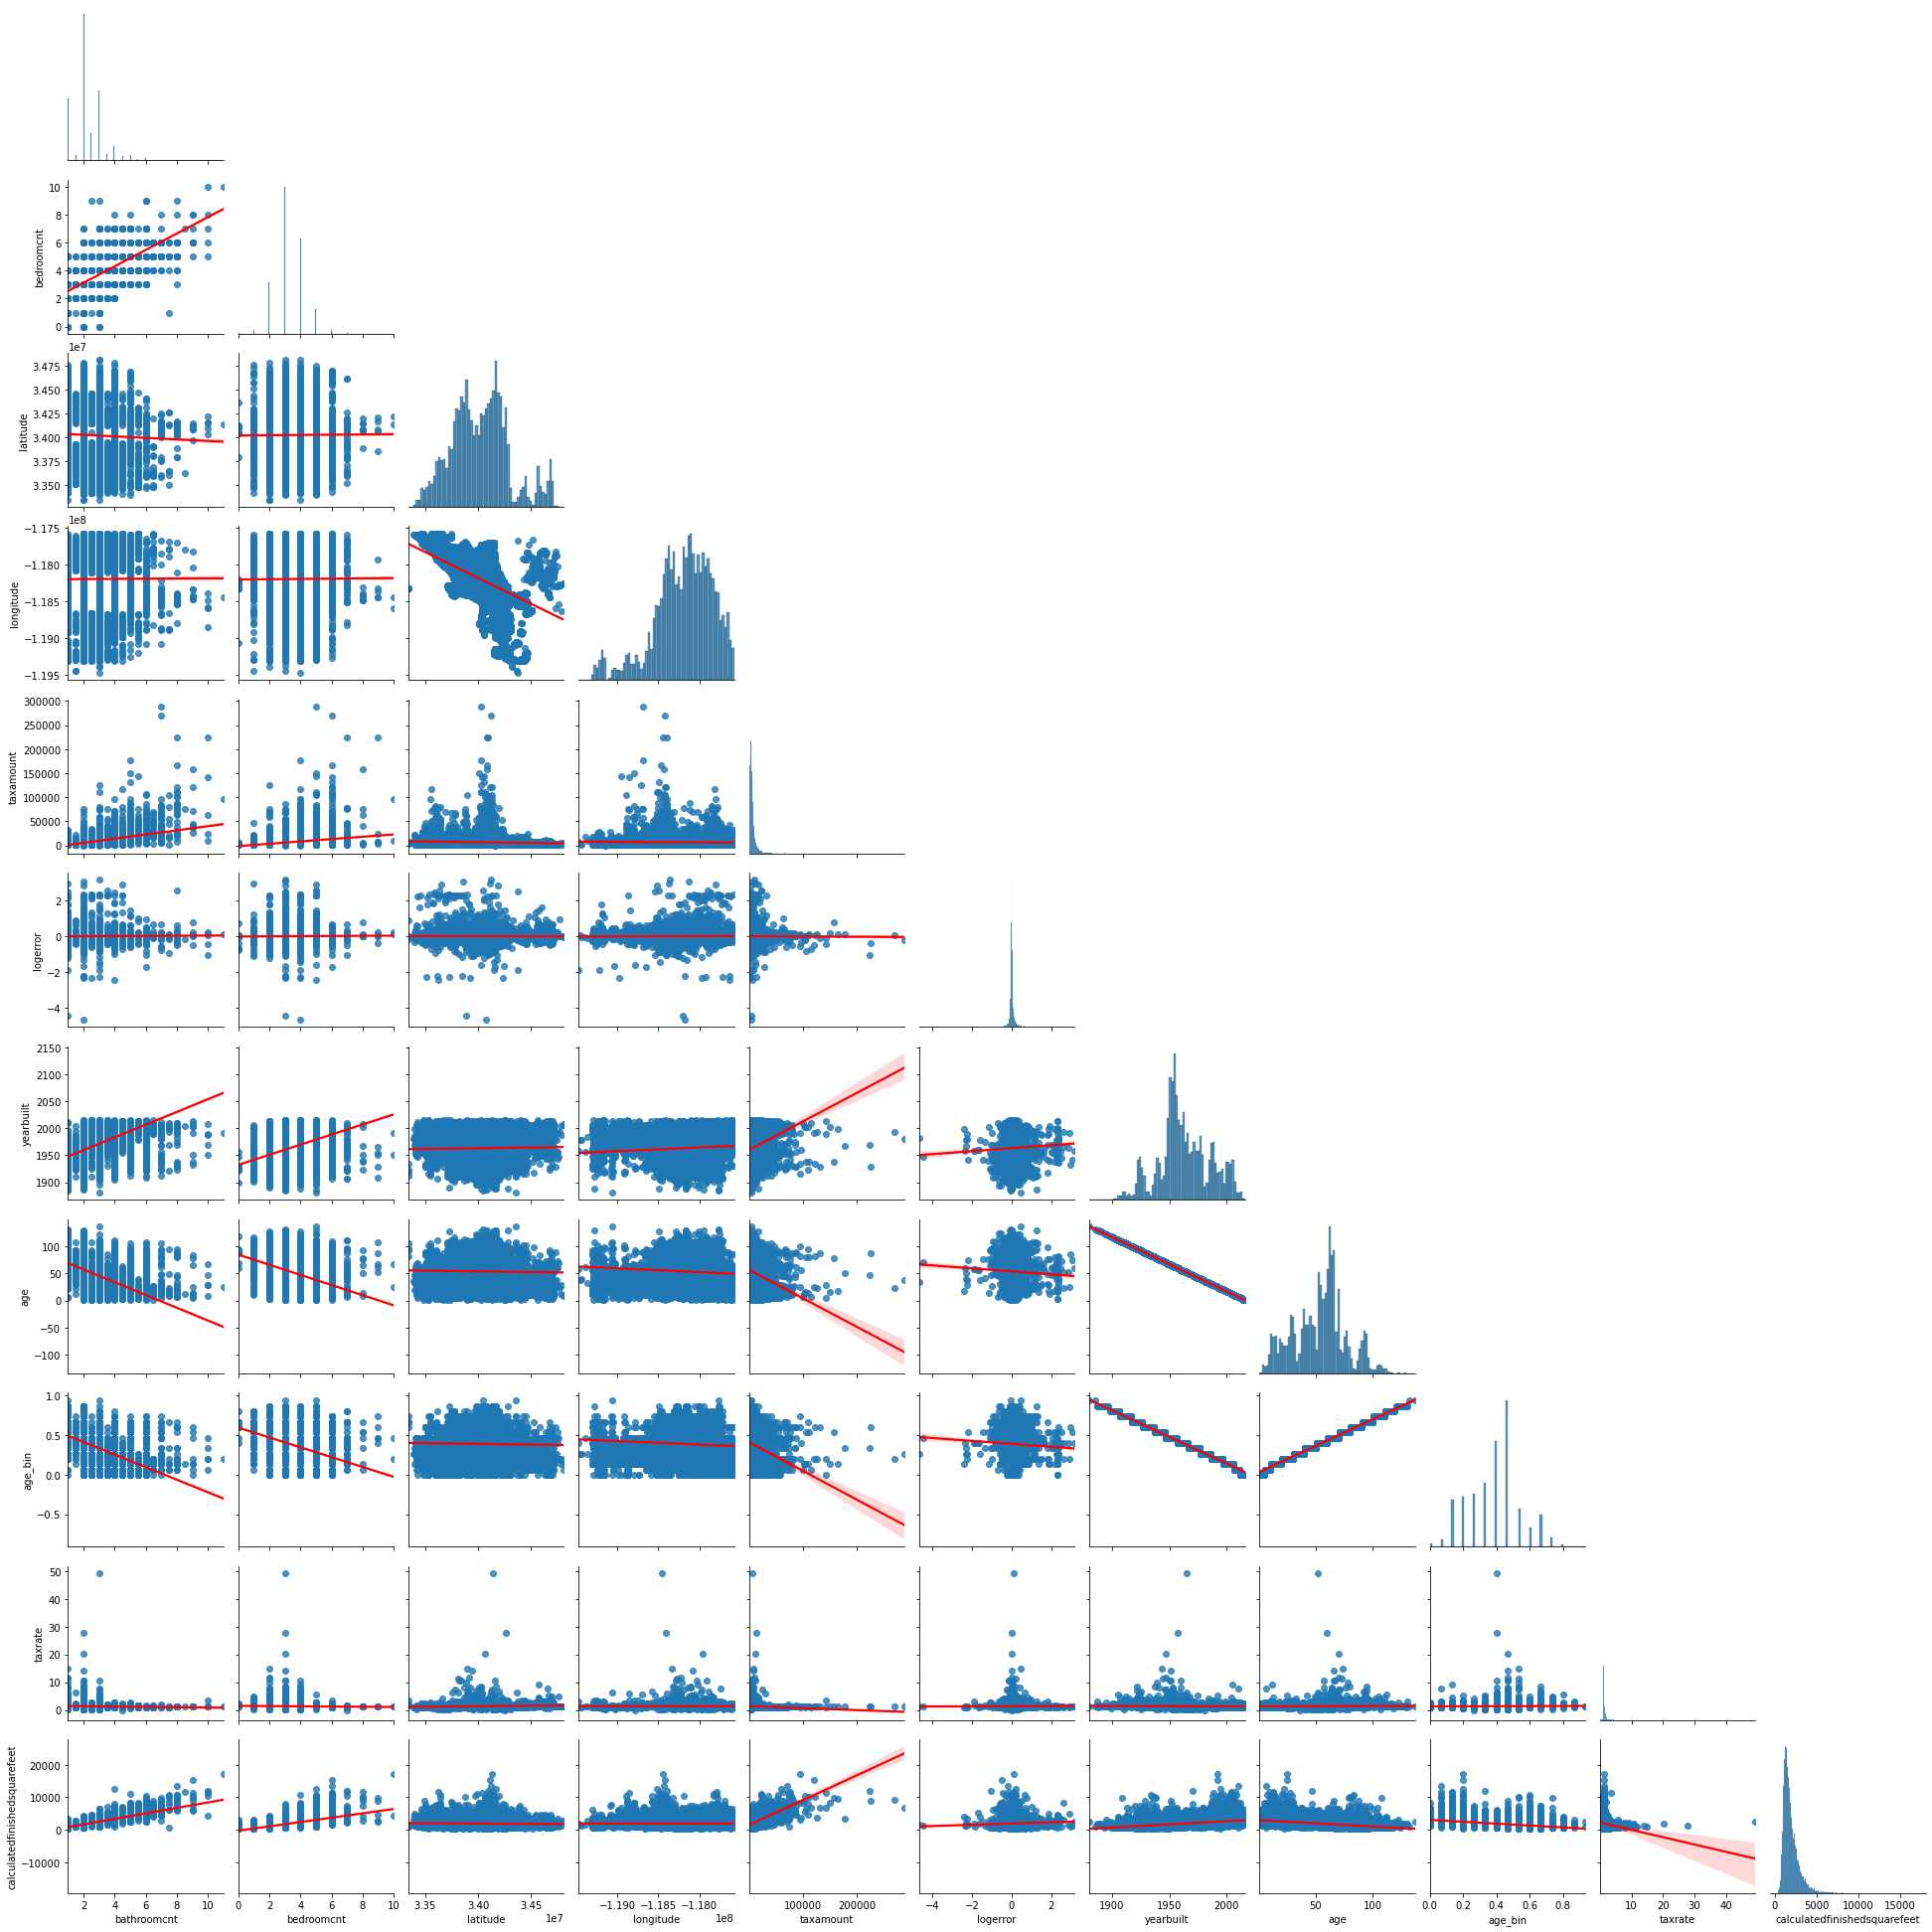

In [21]:
## making a cornered pairplot with red regression line with features I have decided
## will be of most use and the target variable logerror

cols2 = ['bathroomcnt', 'bedroomcnt', 'latitude', 'longitude', 
        'taxamount', 'logerror','yearbuilt', 'age', 'age_bin', 'taxrate', 'county', 'calculatedfinishedsquarefeet']

cols = ['bathroomcnt', 'bedroomcnt', 'latitude', 'longitude', 
        'taxamount', 'logerror','yearbuilt', 'age', 'age_bin', 'taxrate',
        'acres', 'acres_bin', 'sqft_bin' , 'bath_bed_ratio', 'county', 'calculatedfinishedsquarefeet']

sns.pairplot(train[cols2], corner = True, kind = 'reg', 
             plot_kws={'line_kws':{'color':'red'}})

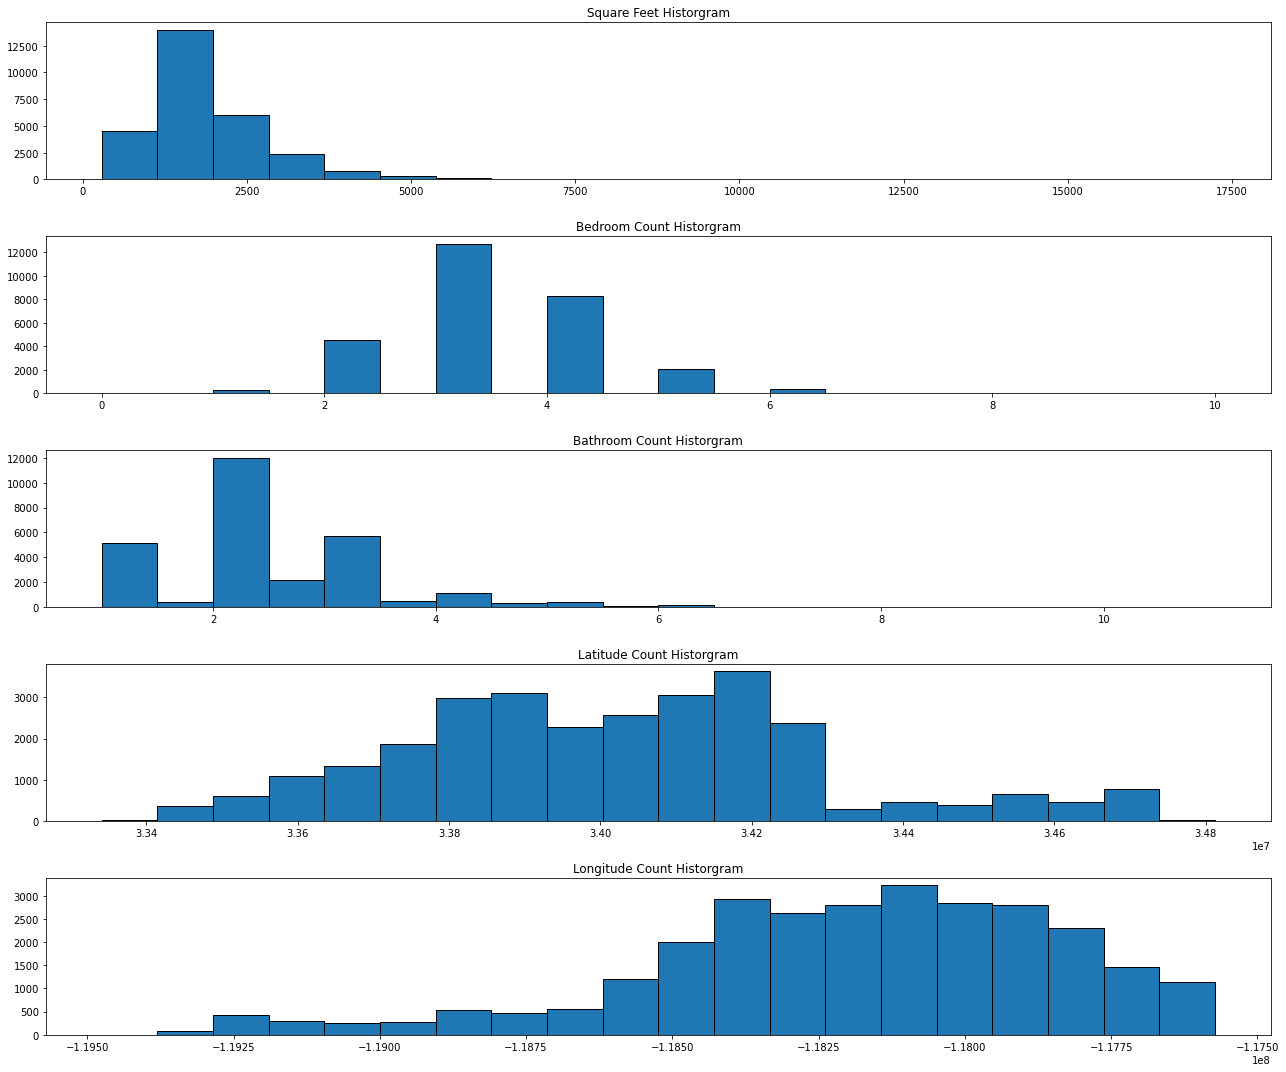

In [22]:
plt.figure(figsize = (18,15))
plt.subplot(5,1,1, title ='Square Feet Historgram')
plt.hist(data=train, x='calculatedfinishedsquarefeet', bins = 20, ec = 'black')

plt.subplot(5,1,2, title ='Bedroom Count Historgram')
plt.hist(data=train, x='bedroomcnt', bins = 20, ec = 'black')

plt.subplot(5,1,3, title ='Bathroom Count Historgram')
plt.hist(data=train, x='bathroomcnt', bins = 20, ec = 'black')

plt.subplot(5,1,4, title ='Latitude Count Historgram')
plt.hist(data=train, x='latitude', bins = 20, ec = 'black')

plt.subplot(5,1,5, title ='Longitude Count Historgram', )
plt.hist(data=train, x='longitude', bins = 20, ec = 'black')

plt.tight_layout()
plt.show()

## Relationships

Relationship between Latitude and Logerror(?)


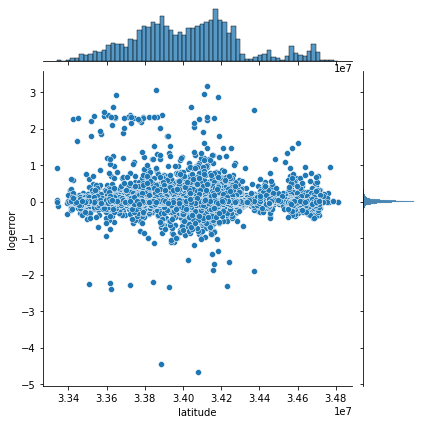

In [23]:
print('Relationship between Latitude and Logerror(?)')
sns.jointplot(x='latitude', y='logerror', data=train)
plt.xlabel('Latitude')
plt.ylabel('Log Error')
plt.show()

Relationship between Longitude and Logerror(?)


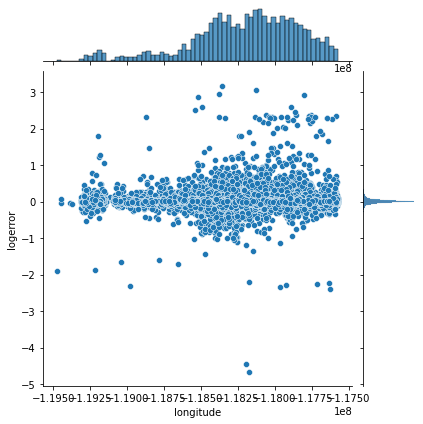

In [24]:
print('Relationship between Longitude and Logerror(?)')
sns.jointplot(x='longitude', y='logerror', data=train)
plt.xlabel('Longitude')
plt.ylabel('Log Error')
plt.show()

Relationship between Square Feet and Logerror(?)


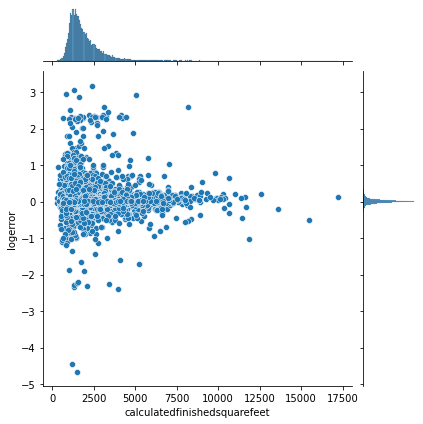

In [25]:
print('Relationship between Square Feet and Logerror(?)')
sns.jointplot(x='calculatedfinishedsquarefeet', y='logerror', data=train)
plt.xlabel('Square Feet')
plt.ylabel('Log Error')
plt.show()

Relationship between # of Bedrooms and Logerror(?)


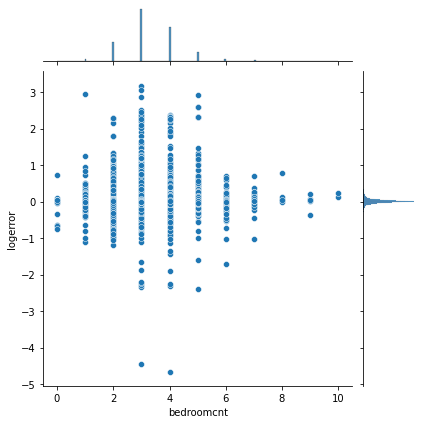

In [26]:
print('Relationship between # of Bedrooms and Logerror(?)')
sns.jointplot(x='bedroomcnt', y='logerror', data=train)
plt.xlabel('Bedroom Count')
plt.ylabel('Log Error')
plt.show()

Relationship between # of Bathrooms and Logerror(?)


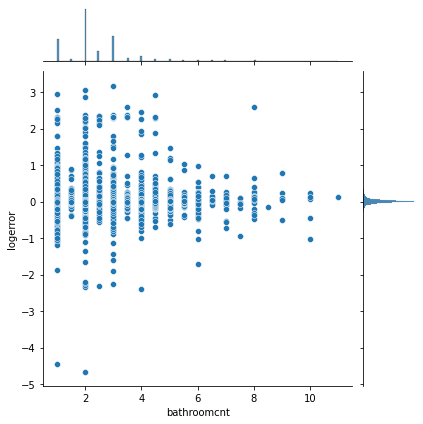

In [27]:
print('Relationship between # of Bathrooms and Logerror(?)')
sns.jointplot(x='bathroomcnt', y='logerror', data=train)
plt.xlabel('Bathroom Count')
plt.ylabel('Log Error')
plt.show()

Relationship between Tax Amount and Logerror(?)


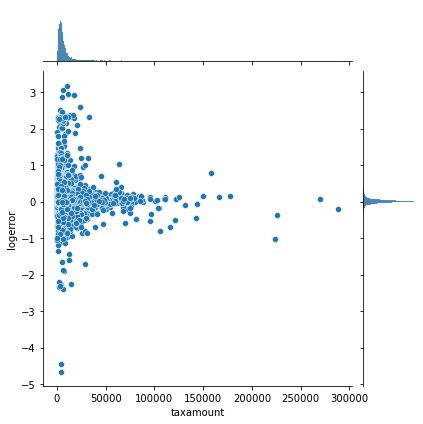

In [28]:
print('Relationship between Tax Amount and Logerror(?)')
sns.jointplot(x='taxamount', y='logerror', data=train)
plt.xlabel('Tax Amount')
plt.ylabel('Log Error')
plt.show()

Relationship between the Year Built and Logerror(?)


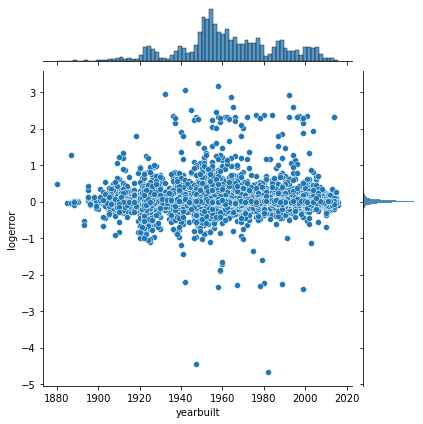

In [29]:
print('Relationship between the Year Built and Logerror(?)')
sns.jointplot(x='yearbuilt', y='logerror', data=train)
plt.xlabel('Year Built')
plt.ylabel('Log Error')
plt.show()

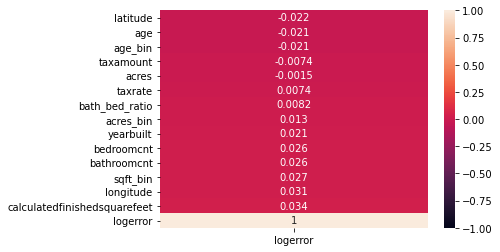

In [30]:
heatmap_cols = train[cols] ## <-- making a sub dataframe to only look at the columns
## I want to see correlations for in a heatmap

sns.heatmap(heatmap_cols.corr()[['logerror']].sort_values(by='logerror'), annot = True,
           vmin = -1, vmax = 1)   ## <-- making my heatmap
plt.show()

## Exploring Clusters

In [31]:
## First we are going to make train, validate, test the columns we want 
## for easier exploration

train = train[cols]
validate = validate[cols]
test = test[cols]

train.shape, validate.shape, test.shape ## <-- checking to see that we have the right amount of columns now

((28313, 16), (12135, 16), (10112, 16))

In [32]:
train.head()  ## <-- looking at out train dataframe 

bathroomcnt  bedroomcnt    latitude    longitude  taxamount  logerror  \
38208          2.0         4.0  34301175.0 -118458283.0     744.92  0.050380   
71943          1.0         3.0  34205841.0 -118569719.0    4827.35  0.031721   
26640          3.0         5.0  33973025.0 -118091262.0    4560.80 -0.024260   
6803           4.0         5.0  33977454.0 -117903393.0    5838.96  0.153838   
75193          2.0         3.0  34112387.0 -117735062.0    4018.67  0.000536   

       yearbuilt   age  age_bin   taxrate     acres  acres_bin  sqft_bin  \
38208     1954.0  63.0    0.466  1.272128  0.138843        0.1       0.2   
71943     1951.0  66.0    0.466  1.203759  0.162534        0.2       0.1   
26640     1950.0  67.0    0.466  1.294398  0.120202        0.1       0.5   
6803      1992.0  25.0    0.200  1.251334  0.245868        0.2       0.7   
75193     1964.0  53.0    0.400  1.281451  0.263935        0.3       0.4   

       bath_bed_ratio       county  calculatedfinishedsquarefeet  
38208        0.500000  Los Angeles                        1170.0  
71943        0.333333  Los Angeles                         980.0  
26640        0.600000  Los Angeles                        2375.0  
6803         0.800000  Los Angeles                        3255.0  
75193        0.666667  Los Angeles                        1768.0

<function matplotlib.pyplot.show(close=None, block=None)>

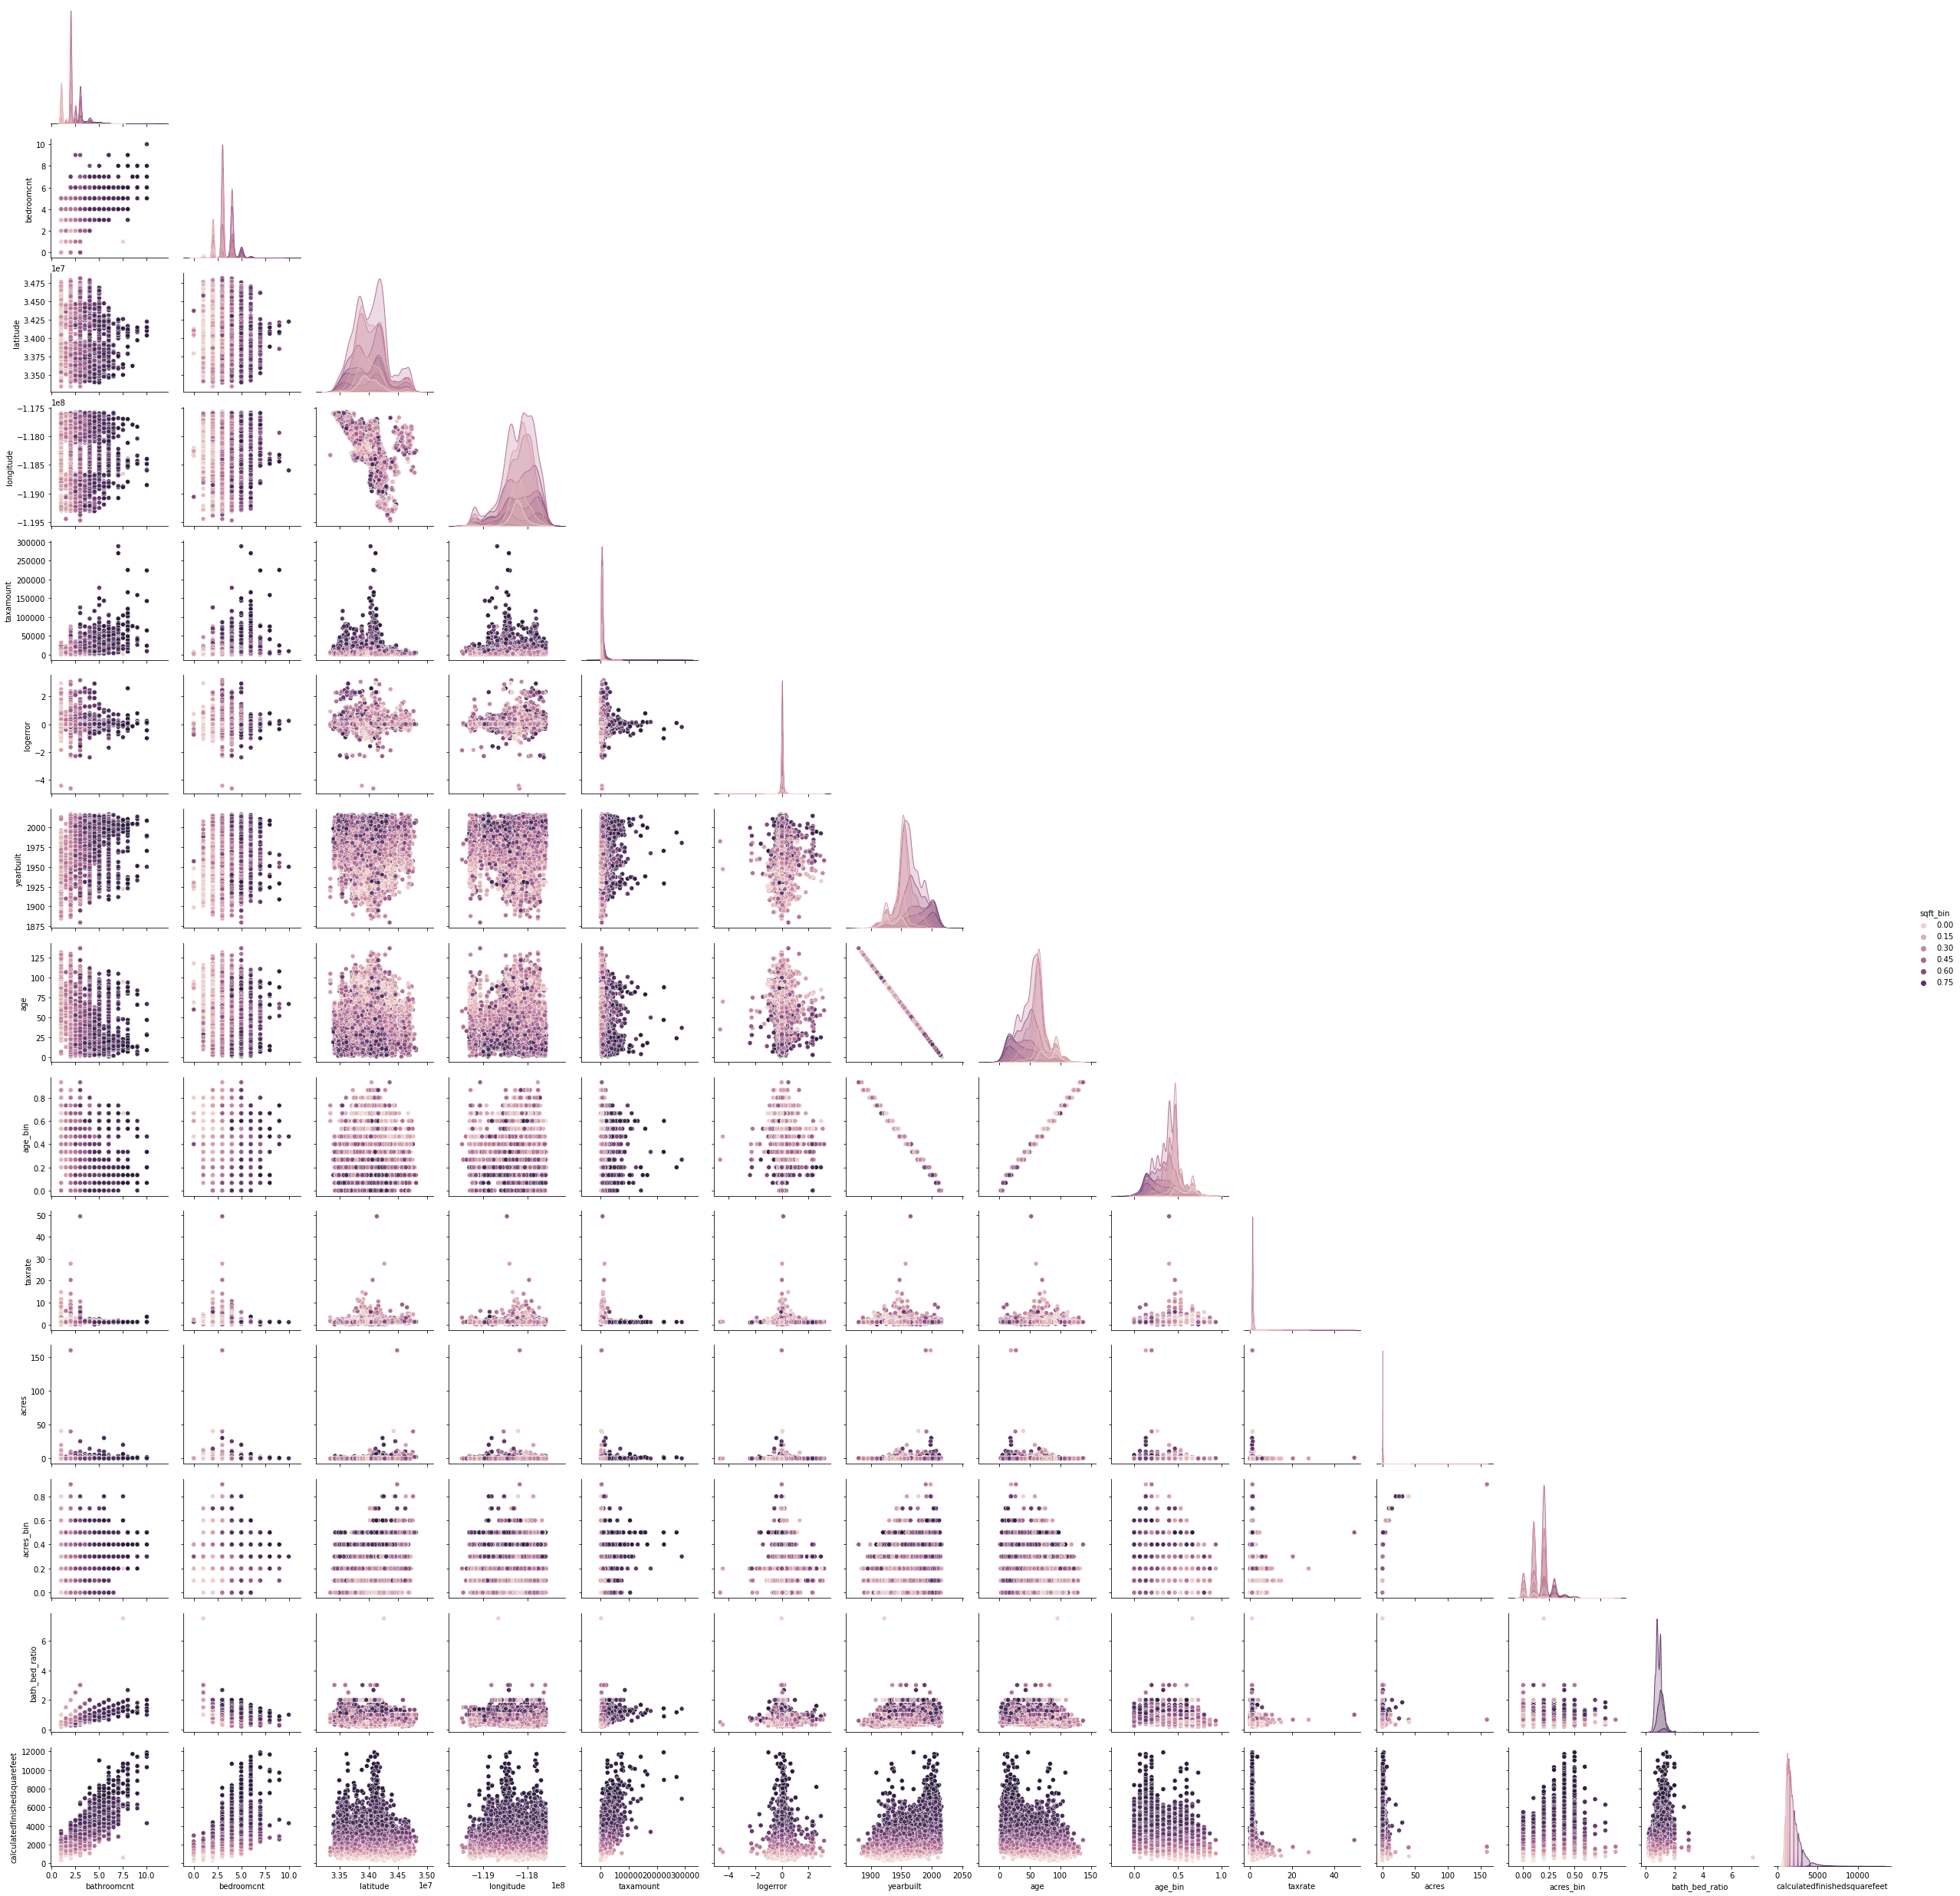

In [33]:
sns.pairplot(data = train, corner = True, hue = 'sqft_bin')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

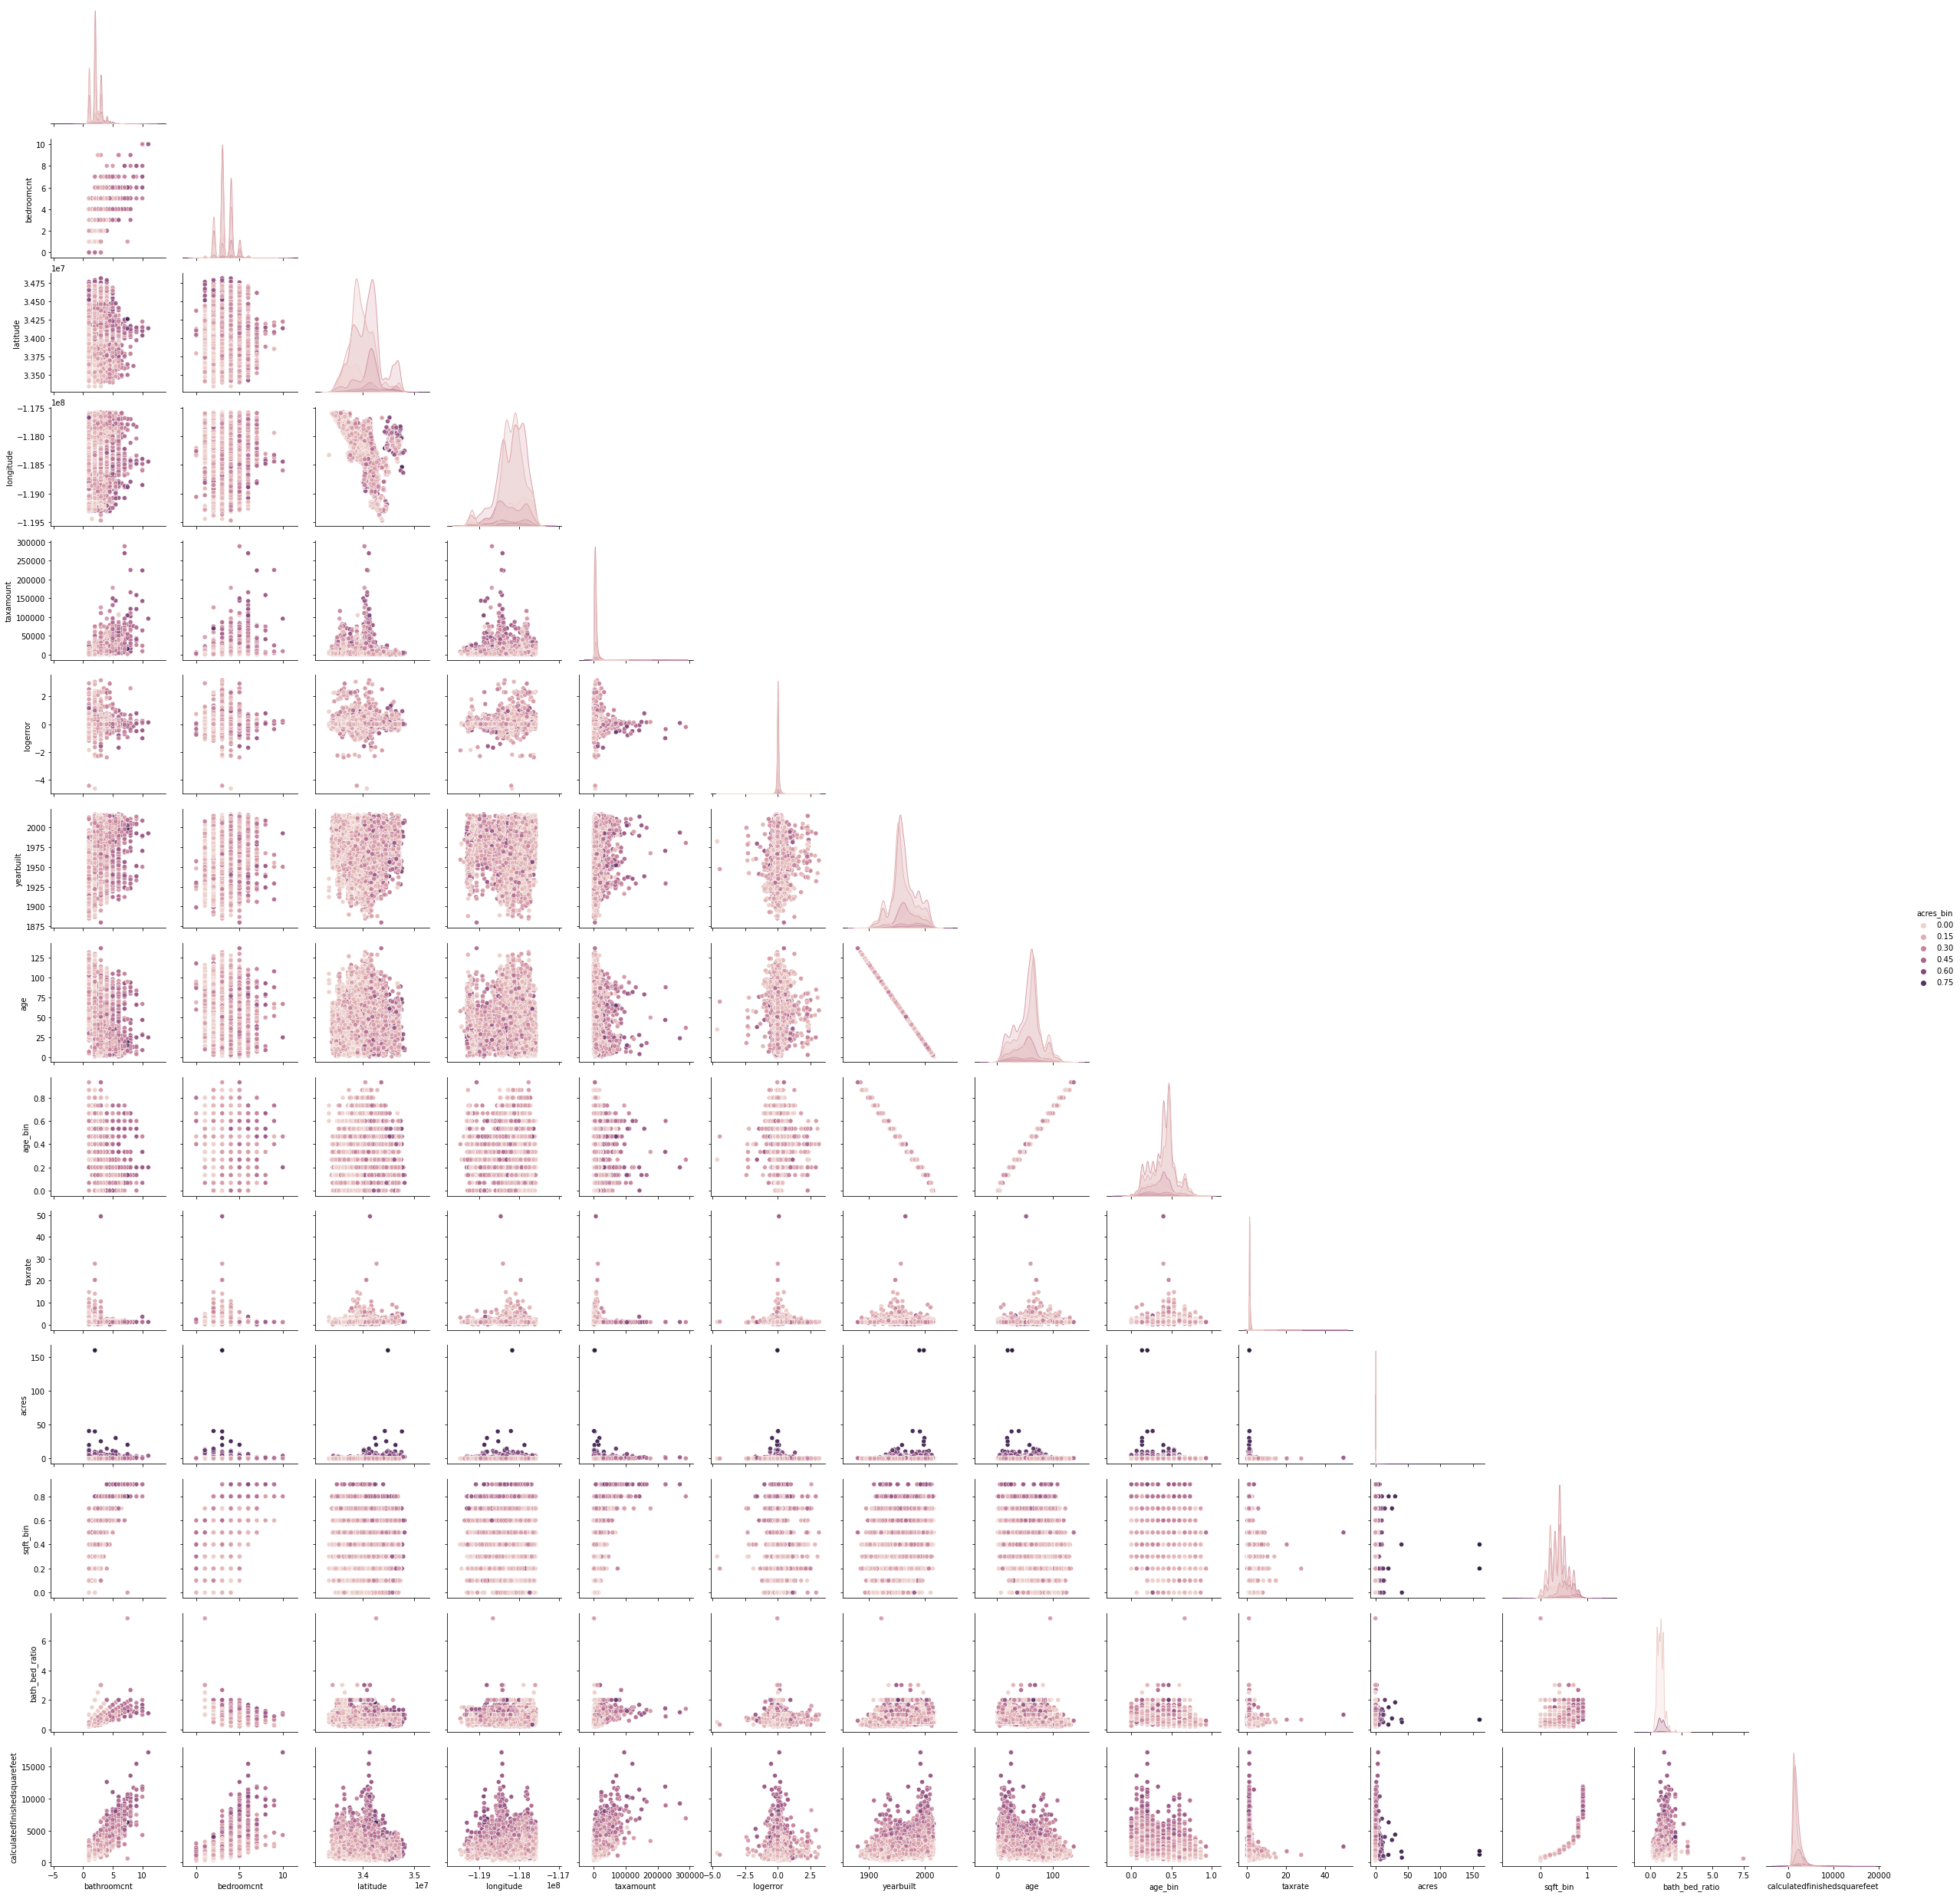

In [34]:
sns.pairplot(data = train, corner = True, hue = 'acres_bin')
plt.show

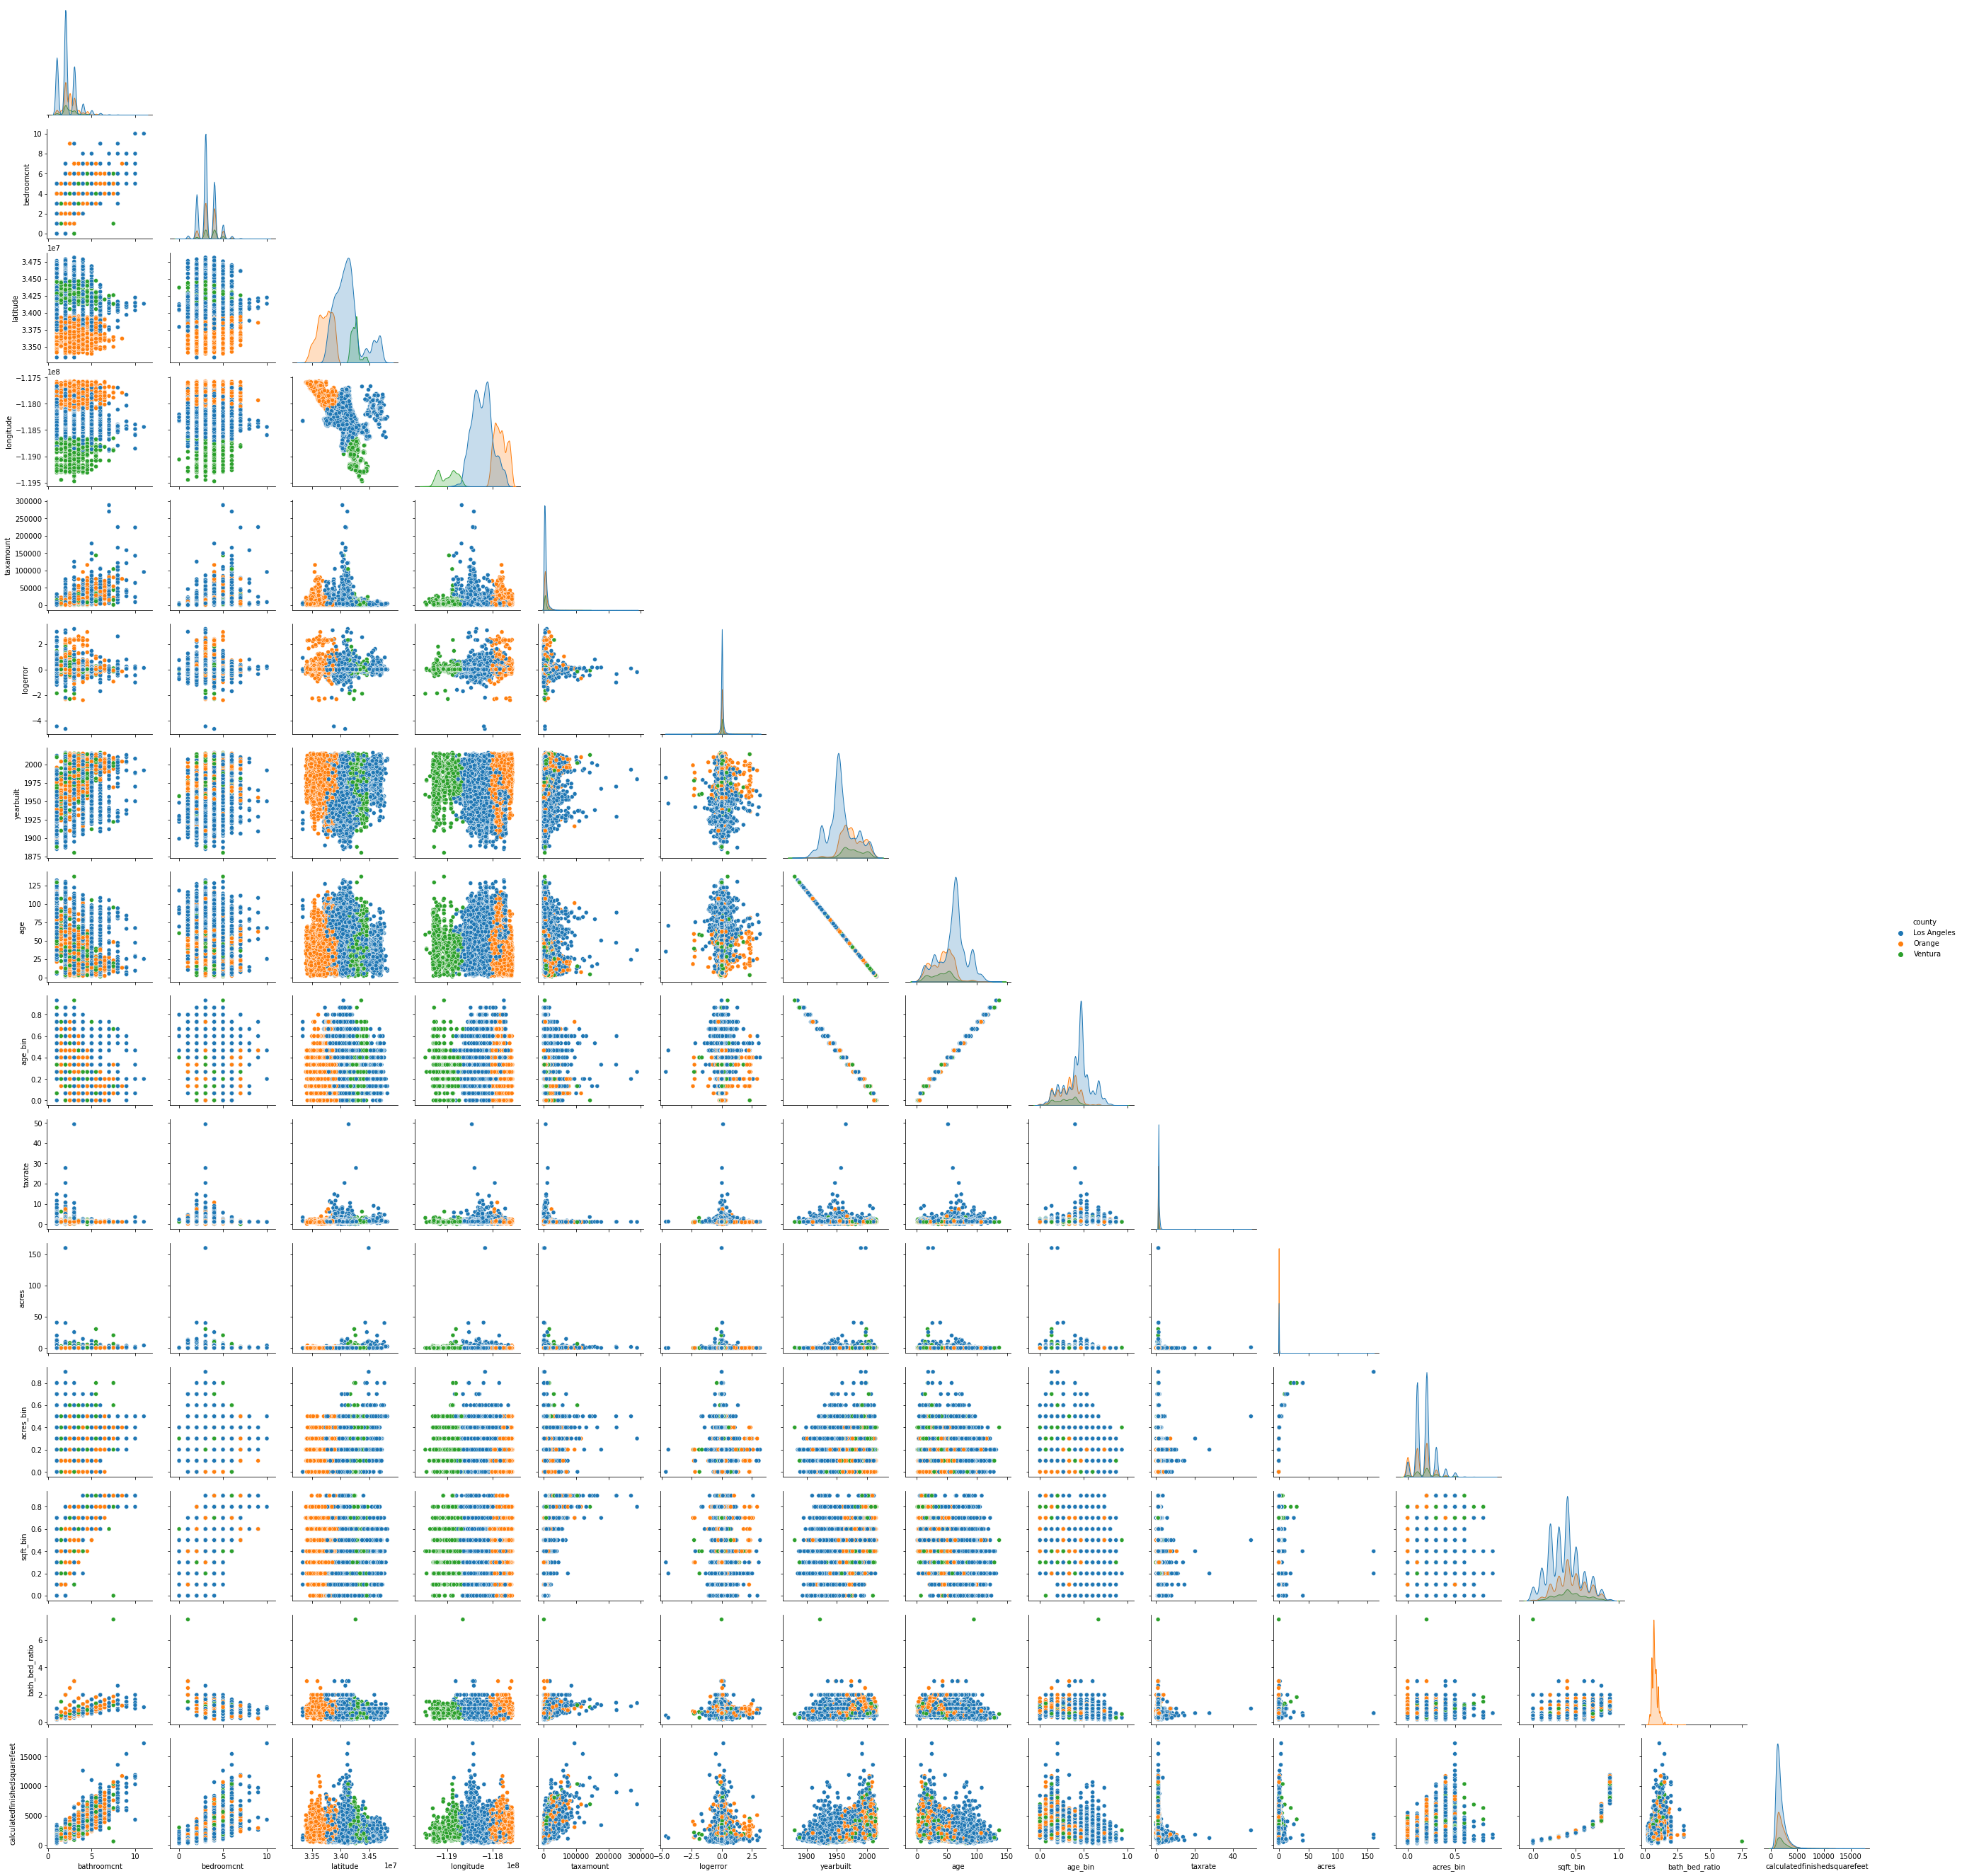

In [35]:
sns.pairplot(train, corner = True, hue = 'county')

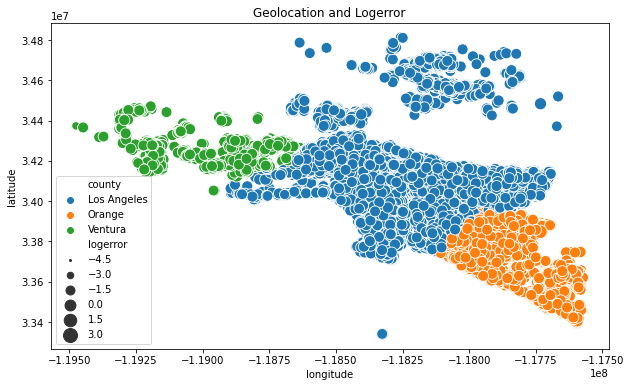

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='county', size='logerror', sizes=(0,200), data=train)
plt.legend()
plt.title('Geolocation and Logerror')
plt.show()

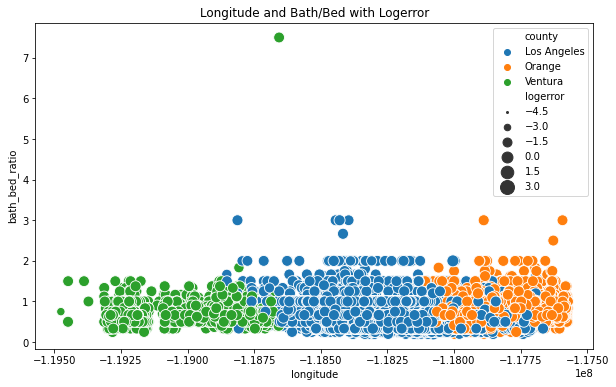

In [37]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='longitude', y='bath_bed_ratio', hue='county', size='logerror', sizes=(0,200), data=train)
plt.legend()
plt.title('Longitude and Bath/Bed with Logerror')
plt.show()

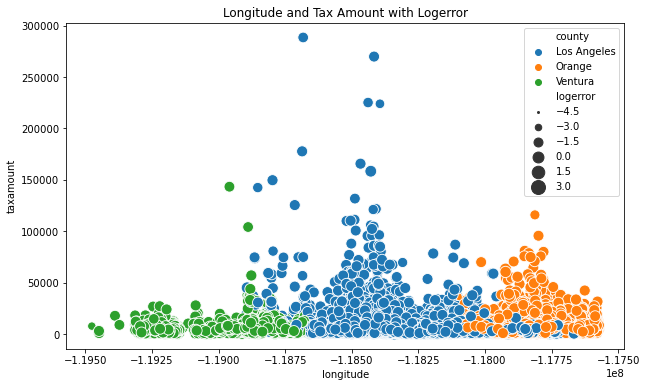

In [38]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='longitude', y='taxamount', hue='county', size='logerror', sizes=(0,200), data=train)
plt.legend()
plt.title('Longitude and Tax Amount with Logerror')
plt.show()

## Statistical Testing

In [39]:
alpha = 0.05 ## <-- Determining alpha value

 ##### Correlation Tests of Longitude, latitude, and age
 - To target variable: logerror


 ##### Standard Hypothesis for correlation test of all variables

 - $H_0$ : There is no relationship between these variables

 - $H_a$ : There is evidence to suggest there is a realtionhip between these two variables

In [40]:
## performing correlation test on longitude because the heat map showed
## a good correlation value with target variable.

## Now we test it to determine if it is a significant relationship

corr, p = stats.pearsonr(train.longitude, train.logerror)
corr, p

(0.0308284407177396, 2.1217519170758995e-07)

With a correlation of 0.03 and a p value less than our alpha 0.05 we can conclude that there is evidence to suggest there is a significant realtionship between the longitude of a single unit home and its associated logerror, thus accepting the alternate hypothesis


In [41]:
## performing correlation test on latitude because the heat map showed
## a good correlation value with target variable.

## Now we test it to determine if it is a significant relationship

corr, p = stats.pearsonr(train.latitude, train.logerror)
corr, p

(-0.021611264196748813, 0.0002761785040643061)

With a correlation of 0.02 and a p value less than our alpha 0.05 we can conclude that there is evidence to suggest there is a significant realtionship between the latitude of a single unit home and its associated logerror, thus accepting the alternate hypothesis


In [42]:
## performing correlation test on age because the heat map showed
## a good correlation value with target variable.

## Now we test it to determine if it is a significant relationship

corr, p = stats.pearsonr(train.age, train.logerror)
corr, p

(-0.020896488283362376, 0.0004374917742745773)

With a high correlation of -0.02 and a p value less than our alpha 0.05 we can conclude that there is evidence to suggest there is a significant realtionship between the age of a single unit home and its associated logerror, thus accepting the alternate hypothesis


#### Tailed T Test's


 - $H_0$: Houses that are located in Los Angeles has no effect on their logerror value and are independent

 - $H_a$: Houses that are located in Los Angeles county has a significant impact on their log error value

In [43]:
LA_train = train[train.county == 'Los Angeles']

In [44]:
t, p = stats.ttest_ind(train.logerror, LA_train.logerror)
t, p/2

(2.017746363007588, 0.021811701903842184)

With a p value near 0 and less than our alpha 0.05 we can say homes being in Los Angeles county are significantly impacted in regaurds to their logerror value


In [45]:
train.sqft_bin.value_counts()

0.4    7165
0.3    4736
0.2    4414
0.5    4082
0.6    2454
0.7    2079
0.1    1680
0.8     941
0.0     666
0.9      92
Name: sqft_bin, dtype: int64


 - $H_0$: Houses that lie within the largest and smallest square foot bins are not significantly impacted in regaurds to their logerror value

 - $H_a$: Houses that lie within the largest and smallest square foot bins are significantly impacted in regaurds to their logerror value

In [46]:
sqft_train = train[train.sqft_bin == 0.4]
sqft_train2 = train[train.sqft_bin == 0.9]

t, p = stats.ttest_ind(sqft_train2.logerror, sqft_train.logerror)
t, p

(4.107648030276793, 4.041027161354705e-05)

With a p value near 0 and less than our alpha 0.05 we can say homes lying within the highest and lowest square foot bins are significantly impacted in regaurds to their logerror value

#### Making Clusters

In [47]:
## splitting into x and y's

X_train, y_train = train.drop(columns = 'logerror'), train['logerror']
X_validate, y_validate = validate.drop(columns = 'logerror'), validate['logerror']
X_test, y_test = test.drop(columns = 'logerror'), test['logerror']

In [48]:
X_train.head()

bathroomcnt  bedroomcnt    latitude    longitude  taxamount  yearbuilt  \
38208          2.0         4.0  34301175.0 -118458283.0     744.92     1954.0   
71943          1.0         3.0  34205841.0 -118569719.0    4827.35     1951.0   
26640          3.0         5.0  33973025.0 -118091262.0    4560.80     1950.0   
6803           4.0         5.0  33977454.0 -117903393.0    5838.96     1992.0   
75193          2.0         3.0  34112387.0 -117735062.0    4018.67     1964.0   

        age  age_bin   taxrate     acres  acres_bin  sqft_bin  bath_bed_ratio  \
38208  63.0    0.466  1.272128  0.138843        0.1       0.2        0.500000   
71943  66.0    0.466  1.203759  0.162534        0.2       0.1        0.333333   
26640  67.0    0.466  1.294398  0.120202        0.1       0.5        0.600000   
6803   25.0    0.200  1.251334  0.245868        0.2       0.7        0.800000   
75193  53.0    0.400  1.281451  0.263935        0.3       0.4        0.666667   

            county  calculatedfinishedsquarefeet  
38208  Los Angeles                        1170.0  
71943  Los Angeles                         980.0  
26640  Los Angeles                        2375.0  
6803   Los Angeles                        3255.0  
75193  Los Angeles                        1768.0

In [49]:
scaled_cols = ['bathroomcnt', 'bedroomcnt', 'latitude', 'longitude', 'taxamount', 'yearbuilt', 'age', 'taxrate',
              'acres', 'calculatedfinishedsquarefeet']
X_train_scaled, X_validate_scaled, X_test_scaled = standard_data_scale(X_train[scaled_cols], 
                                                                       X_validate[scaled_cols], 
                                                                       X_test[scaled_cols])

In [50]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((28313, 10), (12135, 10), (10112, 10))

In [51]:
y_train.head()

38208    0.050380
71943    0.031721
26640   -0.024260
6803     0.153838
75193    0.000536
Name: logerror, dtype: float64

Geolocation Clusters


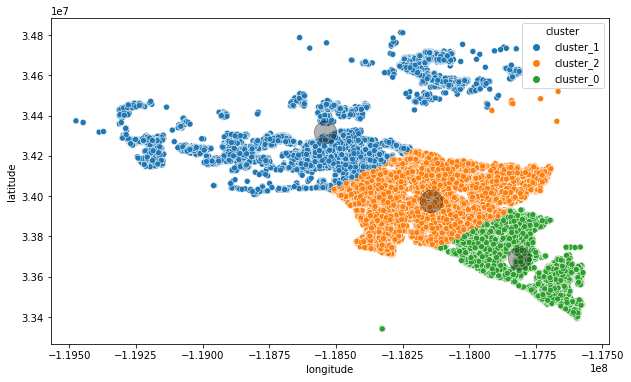

In [52]:
X = train[['longitude', 'latitude']]
df, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 3)
create_scatter_plot('longitude', 'latitude', train, kmeans, X_scaled, scaler)
print('Geolocation Clusters')

Clusters from age and property sqaure footage


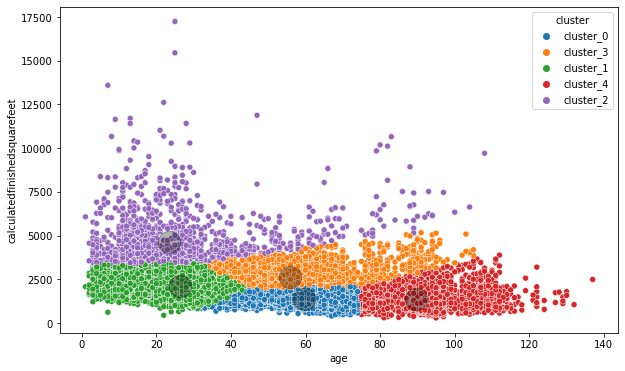

In [53]:
X = train[['age', 'calculatedfinishedsquarefeet']]
df, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 5)
create_scatter_plot('age', 'calculatedfinishedsquarefeet', train, kmeans, X_scaled, scaler)
print('Clusters from age and property sqaure footage')

Clusters from longitude and taxamount


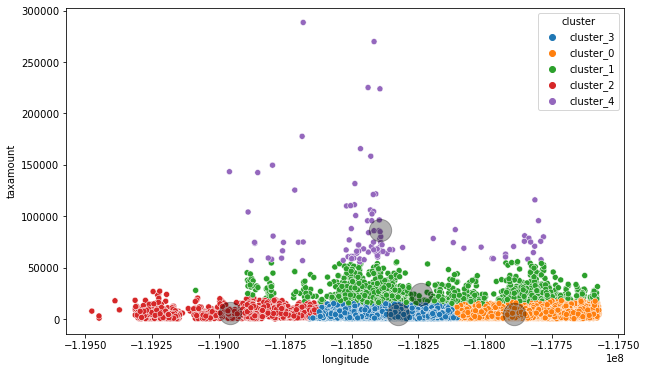

In [54]:
X = train[['longitude', 'taxamount']]
df, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 5)
create_scatter_plot('longitude', 'taxamount', train, kmeans, X_scaled, scaler)
print('Clusters from longitude and taxamount')

In [55]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((28313, 10), (12135, 10), (10112, 10))

In [56]:
y_train.shape, y_validate.shape, y_test.shape

((28313,), (12135,), (10112,))

#### Making Predicted Clusters

##### Taxamount and Longitude

In [57]:
X = X_train_scaled[['taxamount', 'longitude']] ## <-- defining the thing

kmeans = KMeans(n_clusters = 5)

kmeans.fit(X) ## << fit the thing

kmeans.predict(X) ## <<-- predict the clusters

X_train_scaled['cluster'] = kmeans.predict(X) ## <--making our cluster column
X_train_scaled.sample(5)  ## <-- looking at our cluster column

bathroomcnt  bedroomcnt  latitude  longitude  taxamount  yearbuilt  \
3190     -0.295414   -0.330481  0.779622  -0.647046  -0.527134  -0.314122   
9789      0.703696    0.753248 -0.181184   0.792704   0.286309   0.871667   
77321     1.702805    0.753248  0.160349  -0.356569   0.242658   0.344650   
33982    -0.295414   -1.414210  0.076719  -0.837718  -0.390944  -1.631665   
52569     2.701915    0.753248 -0.091779  -0.629605   0.815753   1.003422   

            age   taxrate     acres  calculatedfinishedsquarefeet  cluster  
3190   0.314122 -0.101356 -0.068865                     -0.498318        3  
9789  -0.871667 -0.203012 -0.016155                      0.478113        0  
77321 -0.344650 -0.172342  0.019384                      1.969519        3  
33982  1.631665  0.121810 -0.022039                      0.298377        3  
52569 -1.003422 -0.186935  0.109171                      2.349186        3

Text(0.5, 1.0, 'Change in inertia as k increases')

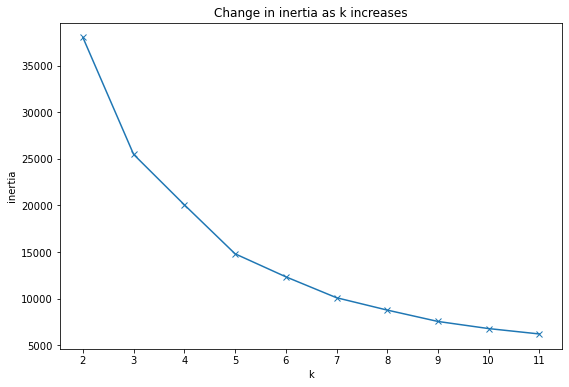

In [58]:
plt.figure(figsize=(9, 6))
pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
plt.xticks(range(2, 12))
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Change in inertia as k increases')

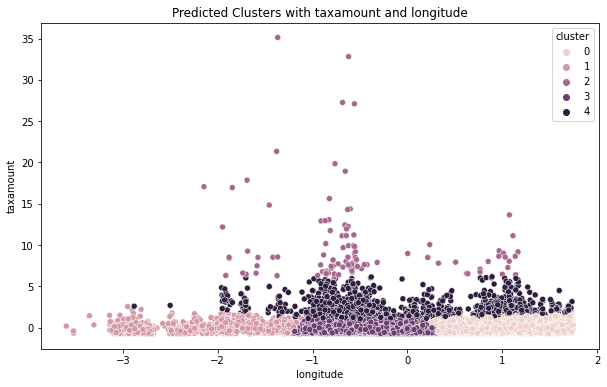

In [59]:
# predicted clusters

plt.figure(figsize = (10,6))
sns.scatterplot(x = 'longitude', y = 'taxamount', data = X_train_scaled, hue = 'cluster')
plt.title('Predicted Clusters with taxamount and longitude')
plt.xlabel('longitude')
plt.ylabel('taxamount')
plt.show()

In [60]:
X = X_validate_scaled[['taxamount', 'longitude']] ## <-- defining the thing

kmeans = KMeans(n_clusters = 5)

kmeans.fit(X) ## << fit the thing

kmeans.predict(X) ## <<-- predict the clusters

X_validate_scaled['cluster'] = kmeans.predict(X) ## <--making our cluster column

In [61]:
X_validate_scaled.shape, y_validate.shape

((12135, 11), (12135,))

In [62]:
X = X_test_scaled[['taxamount', 'longitude']] ## <-- defining the thing

kmeans = KMeans(n_clusters = 5)

kmeans.fit(X) ## << fit the thing

kmeans.predict(X) ## <<-- predict the clusters

X_test_scaled['cluster'] = kmeans.predict(X) ## <--making our cluster column

In [63]:
X_test_scaled.shape, y_test.shape

((10112, 11), (10112,))

#### Latitude and Longitude

In [64]:
X = X_train_scaled[['latitude', 'longitude']] ## <-- defining the thing

kmeans = KMeans(n_clusters = 3)

kmeans.fit(X) ## << fit the thing

kmeans.predict(X) ## <<-- predict the clusters

X_train_scaled['cluster1'] = kmeans.predict(X) ## <--making our cluster columns
X_train_scaled.sample(5)  ## <-- looking at our cluster column

bathroomcnt  bedroomcnt  latitude  longitude  taxamount  yearbuilt  \
12672    -1.294523   -1.414210 -0.309176   0.013510  -0.526316  -1.016811   
15232     0.204141    0.753248 -1.390888   1.422879  -0.095573   0.476404   
62016     0.703696    0.753248  1.640695  -0.927277   0.202011   1.135176   
48695     0.703696    0.753248  2.299307  -0.183231  -0.258570   1.530439   
2388     -1.294523   -0.330481 -0.417757   0.286998  -0.194400  -0.577630   

            age   taxrate     acres  calculatedfinishedsquarefeet  cluster  \
12672  1.016811  0.262130 -0.084640                     -1.046614        3   
15232 -0.476404 -0.527517 -0.084779                      0.565962        0   
62016 -1.135176  0.217238 -0.077932                      0.303426        3   
48695 -1.530439  0.350162 -0.013934                      0.491240        3   
2388   0.577630 -0.106573 -0.085556                     -0.849712        3   

       cluster1  
12672         0  
15232         2  
62016         1  
48695         1  
2388          0

Text(0.5, 1.0, 'Change in inertia as k increases')

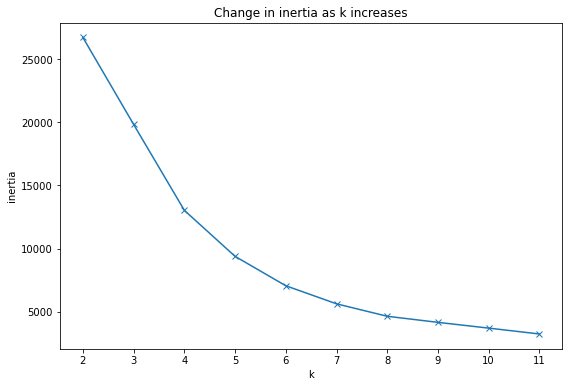

In [65]:
plt.figure(figsize=(9, 6))
pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
plt.xticks(range(2, 12))
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Change in inertia as k increases')

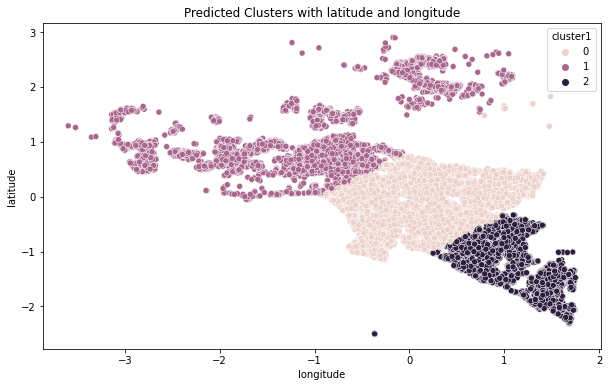

In [66]:
# predicted clusters

plt.figure(figsize = (10,6))
sns.scatterplot(x = 'longitude', y = 'latitude', data = X_train_scaled, hue = 'cluster1')
plt.title('Predicted Clusters with latitude and longitude')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

In [67]:
X = X_validate_scaled[['latitude', 'longitude']] ## <-- defining the thing

kmeans = KMeans(n_clusters = 3)

kmeans.fit(X) ## << fit the thing

kmeans.predict(X) ## <<-- predict the clusters

X_validate_scaled['cluster1'] = kmeans.predict(X) ## <--making our cluster columns
X_validate_scaled.shape, y_validate.shape

((12135, 12), (12135,))

In [68]:
X = X_test_scaled[['latitude', 'longitude']] ## <-- defining the thing

kmeans = KMeans(n_clusters = 3)

kmeans.fit(X) ## << fit the thing

kmeans.predict(X) ## <<-- predict the clusters

X_test_scaled['cluster1'] = kmeans.predict(X) ## <--making our cluster columns
X_test_scaled.shape, y_test.shape

((10112, 12), (10112,))

##### Age and Square Feet 

In [69]:
X = X_train_scaled[['age', 'calculatedfinishedsquarefeet']] ## <-- defining the thing

kmeans = KMeans(n_clusters = 5)

kmeans.fit(X) ## << fit the thing

kmeans.predict(X) ## <<-- predict the clusters

X_train_scaled['cluster2'] = kmeans.predict(X) ## <--making our cluster column
X_train_scaled.sample(5)  ## <-- looking at our cluster column

bathroomcnt  bedroomcnt  latitude  longitude  taxamount  yearbuilt  \
49547     0.703696    1.836977  0.039943  -0.574200  -0.512245   0.388568   
8699      0.703696    0.753248  0.936889  -2.759286  -0.447029   0.212896   
31347    -0.295414   -0.330481  2.191677   0.981070  -0.672500   0.959504   
48195    -1.294523   -1.414210 -0.101952  -0.309343  -0.735348  -2.334355   
53563    -0.295414   -0.330481 -0.322749   0.254462  -0.299856  -0.358040   

            age   taxrate     acres  calculatedfinishedsquarefeet  cluster  \
49547 -0.388568  0.012533 -0.073973                      1.746363        3   
8699  -0.212896 -0.512734 -0.063881                     -0.060085        1   
31347 -0.959504  0.298142  0.448677                     -0.897170        0   
48195  2.334355  0.235765 -0.079796                     -0.962804        3   
53563  0.358040 -0.103816 -0.046803                      0.016656        3   

       cluster1  cluster2  
49547         0         2  
8699          1         0  
31347         1         3  
48195         0         4  
53563         0         0

Text(0.5, 1.0, 'Change in inertia as k increases')

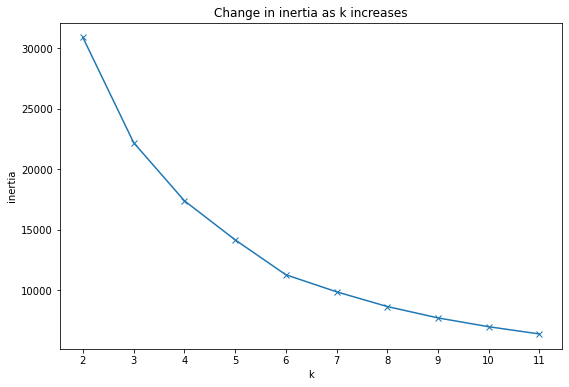

In [70]:
plt.figure(figsize=(9, 6))
pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
plt.xticks(range(2, 12))
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Change in inertia as k increases')

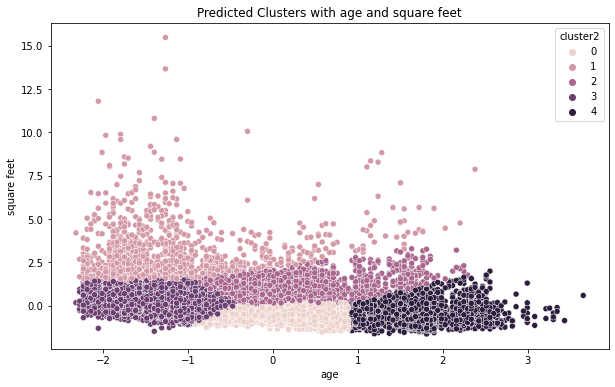

In [71]:
# predicted clusters

plt.figure(figsize = (10,6))
sns.scatterplot(x = 'age', y = 'calculatedfinishedsquarefeet', data = X_train_scaled, hue = 'cluster2')
plt.title('Predicted Clusters with age and square feet')
plt.xlabel('age')
plt.ylabel('square feet')
plt.show()

In [72]:
X = X_validate_scaled[['age', 'calculatedfinishedsquarefeet']] ## <-- defining the thing

kmeans = KMeans(n_clusters = 5)

kmeans.fit(X) ## << fit the thing

kmeans.predict(X) ## <<-- predict the clusters

X_validate_scaled['cluster2'] = kmeans.predict(X) ## <--making our cluster column
X_validate_scaled.shape, y_validate.shape

((12135, 13), (12135,))

In [73]:
X = X_test_scaled[['age', 'calculatedfinishedsquarefeet']] ## <-- defining the thing

kmeans = KMeans(n_clusters = 5)

kmeans.fit(X) ## << fit the thing

kmeans.predict(X) ## <<-- predict the clusters

X_test_scaled['cluster2'] = kmeans.predict(X) ## <--making our cluster column
X_test_scaled.shape, y_test.shape

((10112, 13), (10112,))

#### Modeling

In [74]:
X_train_scaled.head()

bathroomcnt  bedroomcnt  latitude  longitude  taxamount  yearbuilt  \
38208    -0.295414    0.753248  1.024315  -0.738341  -0.695430  -0.401958   
71943    -1.294523   -0.330481  0.674309  -1.051411  -0.187110  -0.533712   
26640     0.703696    1.836977 -0.180446   0.292774  -0.220299  -0.577630   
6803      1.702805    1.836977 -0.164186   0.820577  -0.061150   1.266930   
75193    -0.295414   -0.330481  0.331204   1.293489  -0.287802   0.037223   

            age   taxrate     acres  calculatedfinishedsquarefeet  cluster  \
38208  0.401958 -0.112169 -0.068508                     -0.750756        3   
71943  0.533712 -0.241769 -0.052485                     -0.942609        3   
26640  0.577630 -0.069954 -0.081115                      0.465996        0   
6803  -1.266930 -0.151587  0.003874                      1.354579        0   
75193 -0.037223 -0.094496  0.016093                     -0.146924        0   

       cluster1  cluster2  
38208         1         0  
71943         1         0  
26640         0         2  
6803          0         3  
75193         0         0

In [75]:
X_validate_scaled.head()

bathroomcnt  bedroomcnt  latitude  longitude  taxamount  yearbuilt  \
59891    -1.294523   -1.414210 -0.292721  -0.420447  -0.413764  -0.665467   
64482    -1.294523   -1.414210  0.685029  -0.429718  -0.684978  -1.192484   
29816    -0.295414   -0.330481 -0.148036   1.015255  -0.331306  -0.006695   
7155     -1.294523   -1.414210 -1.201834   1.155153   0.286854   0.344650   
5940      0.703696    0.753248  2.287478  -0.151260  -0.051835   1.881784   

            age   taxrate     acres  calculatedfinishedsquarefeet  cluster  \
59891  0.665467  0.471964 -0.070915                     -1.143550        3   
64482  1.192484  0.059129  0.049707                     -0.958765        3   
29816  0.006695 -0.201178 -0.001622                     -0.619488        0   
7155  -0.344650 -0.580844 -0.082559                     -0.946648        0   
5940  -1.881784  0.598983  0.011404                      1.538354        3   

       cluster1  cluster2  
59891         2         3  
64482         1         1  
29816         2         3  
7155          0         3  
5940          1         0

In [76]:
X_test_scaled.head()

bathroomcnt  bedroomcnt  latitude  longitude  taxamount  yearbuilt  \
28464    -0.295414   -0.330481  0.306536   0.774969  -0.629624  -0.226285   
10981     0.204141   -0.330481 -1.049946   0.731015  -0.030502   1.179094   
42750     0.703696   -0.330481 -0.273097   0.237881  -0.077350  -0.358040   
76900    -0.295414   -0.330481 -0.682738   0.528041  -0.262350  -0.314122   
17647    -0.295414    0.753248 -0.761893  -0.017804  -0.196016  -0.841139   

            age   taxrate     acres  calculatedfinishedsquarefeet  cluster  \
28464  0.226285  0.435747 -0.058929                     -0.722483        0   
10981 -1.179094 -0.347215 -0.113502                     -0.377147        0   
42750  0.358040 -0.159251 -0.009789                      0.534660        1   
76900  0.314122 -0.293603 -0.059006                     -0.813361        0   
17647  0.841139 -0.202065 -0.078755                     -0.486201        1   

       cluster1  cluster2  
28464         1         0  
10981         2         4  
42750         1         1  
76900         1         0  
17647         1         0

In [77]:
# using select kbest
# define the thing
f_selector = SelectKBest(f_regression, k=4)

# fit the thing
f_selector.fit(X_train_scaled, y_train)

# make the mask 
feature_mask = f_selector.get_support()

# get the list
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

# output the list
f_feature

['longitude', 'calculatedfinishedsquarefeet', 'cluster', 'cluster1']

In [78]:
# use ML algorithim
lm = LinearRegression()

# make the rfe object to select 4
rfe = RFE(lm, 5)

# fit the data using train
rfe.fit(X_train_scaled,y_train)  

# make the mask
feature_mask = rfe.support_

# get the list 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

# outpute the list
rfe_feature

['longitude',
 'taxamount',
 'taxrate',
 'calculatedfinishedsquarefeet',
 'cluster1']

In [79]:
## Turning all my y's into dataframe

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [80]:
features = ['longitude', 'age', 'cluster', 'latitude', 'calculatedfinishedsquarefeet']

X_train_scaled = X_train_scaled[features]
X_validate_scaled = X_validate_scaled[features]
X_test_scaled = X_test_scaled[features]

#### Establishing Median and Mean Baseline

In [81]:
## logerror mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

## logerror_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

## RMSE of logerror_pred_mean train and validate scores
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)

print('Baseline')
print('-----------------------------')
print('RMSE using Median\nTrain/In-Sample: ', round(rmse_train, 4), 
      '\nValidate/Out-of-Sample: ', round(rmse_validate, 4))
print('-----------------------------')

## RMSE of logerror_pred_median train and validate scores
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

## R squared score for baseline
print('-----------------------------')
r2_baseline = r2_score(y_validate.logerror, y_validate.logerror_pred_mean)
print(f'The R squared score for the baseline is {r2_baseline}')

Baseline
-----------------------------
RMSE using Median
Train/In-Sample:  0.1723 
Validate/Out-of-Sample:  0.1854
-----------------------------
RMSE using Mean
Train/In-Sample:  0.1727 
Validate/Out-of-Sample:  0.1856
-----------------------------
The R squared score for the baseline is -0.00012999508777600255


In [82]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_mean)}])

#### Linear Regression

In [83]:
## create the model
lm = LinearRegression(normalize = True)

## fit the model to train
lm.fit(X_train_scaled, y_train.logerror)

## use the model to predict train
y_train['logerror_pred_lm'] = lm.predict(X_train_scaled)

## RMSE score for train
rmse_train = mean_squared_error(y_train.logerror, 
                                y_train.logerror_pred_lm) **(1/2)

## predict validate 
y_validate['logerror_pred_lm'] = lm.predict(X_validate_scaled)

## RMSE score for validate
rmse_validate = mean_squared_error(y_validate.logerror, 
                                y_validate.logerror_pred_lm) **(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ",rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for OLS: {r2_score(y_validate.logerror, y_validate.logerror_pred_lm)}')

RMSE for OLS using LinearRegression
Training/In-Sample:  0.17208551110993967 
Validate/Out-of-Sample:  0.18513737065368716
------------------------------------------------
R squared score for OLS: 0.0027008080754313823


In [84]:
## adding linear regression to a metric dataframe

metric_df = metric_df.append(
    {
    'model': 'OLS LinearRegression',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lm)}, ignore_index=True)

#### Lasso & Lars¶


In [85]:
## create the model
lars = LassoLars(alpha=1.0)

## fit the model to train
lars.fit(X_train_scaled, y_train.logerror)

## use the model to predict train
y_train['logerror_pred_lars'] = lars.predict(X_train_scaled)

## RMSE score for train
rmse_train = mean_squared_error(y_train.logerror, 
                                y_train.logerror_pred_lars) **(1/2)

## predict validate 
y_validate['logerror_pred_lars'] = lars.predict(X_validate_scaled)

## RMSE score for validate
rmse_validate = mean_squared_error(y_validate.logerror, 
                                y_validate.logerror_pred_lars) **(1/2)

print("RMSE for Lasso & Lars \nTraining/In-Sample: ",rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for Lasso & Lars: {r2_score(y_validate.logerror, y_validate.logerror_pred_lars)}')

RMSE for Lasso & Lars 
Training/In-Sample:  0.17229704371782067 
Validate/Out-of-Sample:  0.185399937837164
------------------------------------------------
R squared score for Lasso & Lars: -0.00012999508777600255


In [86]:
## adding Lassor Lars to the dataframe
metric_df = metric_df.append(
    {
    'model': 'LassoLars alpha = 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_lars)}, ignore_index=True)

##### TweedieRegressor

In [87]:
## we are going to use all three features in X scaled so no subset

## create the model
glm = TweedieRegressor(power = 0, alpha = 0)

## fit the model to train
glm.fit(X_train_scaled, y_train.logerror)

## use the model to predict train
y_train['logerror_pred_glm'] = glm.predict(X_train_scaled)

## RMSE score for train
rmse_train = mean_squared_error(y_train.logerror, 
                                y_train.logerror_pred_glm) **(1/2)

## predict validate 
y_validate['logerror_pred_glm'] = glm.predict(X_validate_scaled)

## RMSE score for validate
rmse_validate = mean_squared_error(y_validate.logerror, 
                                   y_validate.logerror_pred_glm) **(1/2)

print("RMSE for TweedieRegressor \nTraining/In-Sample: ",rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for TweedieRegressor: {r2_score(y_validate.logerror, y_validate.logerror_pred_glm)}')

RMSE for TweedieRegressor 
Training/In-Sample:  0.17208552727239737 
Validate/Out-of-Sample:  0.18513936783666776
------------------------------------------------
R squared score for TweedieRegressor: 0.0026792910828443706


In [88]:
## adding TweedieRegressor to the dataframe
metric_df = metric_df.append(
    {
    'model': 'TweedieRegressor alpha = 0',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_glm)}, ignore_index=True)

#### Polynomial Regression

In [89]:
## getting new set of features using degree 3
pf = PolynomialFeatures(degree = 3)

## fitting and transforming scaled X's for lm2 below
X_train_degree2 = pf.fit_transform(X_train_scaled)
X_validate_degree2 = pf.fit_transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [90]:
## we are going to use all three features in X scaled so no subset

## create the model
lm2 = LinearRegression(normalize = True)

## fit the model to train
lm2.fit(X_train_degree2, y_train.logerror)

## use the model to predict train
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)

## RMSE score for train
rmse_train = mean_squared_error(y_train.logerror, 
                                y_train.logerror_pred_lm2) **(1/2)

## predict validate 
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

## RMSE score for validate
rmse_validate = mean_squared_error(y_validate.logerror, 
                                y_validate.logerror_pred_lm2) **(1/2)

print("RMSE for Polynomial Features w/ degrees 3: \nTraining/In-Sample: ",rmse_train, 
      "\nValidate/Out-of-Sample: ", rmse_validate)
print('------------------------------------------------')
print(f'R squared score for Polynomial Features: {r2_score(y_validate.logerror, y_validate.logerror_pred_lm2)}')

RMSE for Polynomial Features w/ degrees 3: 
Training/In-Sample:  0.17156729402579293 
Validate/Out-of-Sample:  0.18514548265748626
------------------------------------------------
R squared score for Polynomial Features: 0.0026134105711510536


In [91]:
## adding Polynomial Regression using 3 degrees to the dataframe
metric_df = metric_df.append(
    {
    'model': 'Polynomial Regression: 3 degrees',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.logerror, y_validate.logerror_pred_glm)}, ignore_index=True)

#### Plotting The Residuals

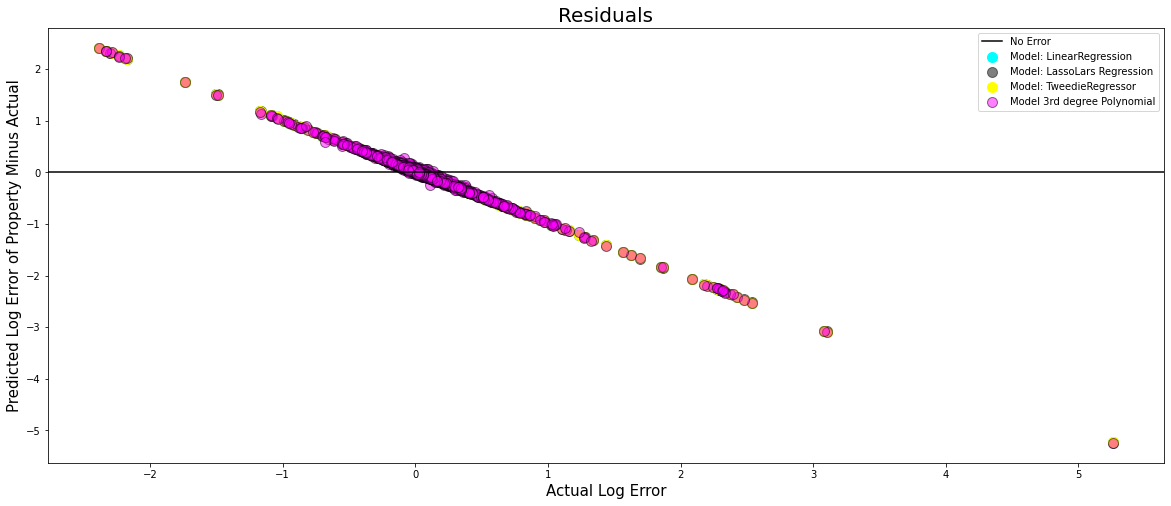

In [92]:
plt.figure(figsize=(20,8))
plt.axhline(label="No Error", color="black")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm-y_validate.logerror, 
            alpha=1, color="cyan", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lars-y_validate.logerror, 
            alpha=.5, color="black", s=100, label="Model: LassoLars Regression")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_glm-y_validate.logerror, 
            alpha=1, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.logerror, y_validate.logerror_pred_lm2-y_validate.logerror, 
            alpha=.5, color="magenta", s=100, edgecolors='black', label="Model 3rd degree Polynomial")
plt.legend()

plt.xlabel("Actual Log Error", fontdict={'fontsize':15})
plt.ylabel("Predicted Log Error of Property Minus Actual", fontdict={'fontsize':15})
plt.title("Residuals", fontdict={'fontsize': 20})
plt.show()

In [93]:
metric_df.sort_values(by= 'rmse_validate')

model  rmse_validate  r^2_validate
1              OLS LinearRegression       0.185137      0.002871
3        TweedieRegressor alpha = 0       0.185139      0.002852
4  Polynomial Regression: 3 degrees       0.185145      0.002852
2               LassoLars alpha = 1       0.185400      0.000000
0                     mean_baseline       0.185619      0.000000

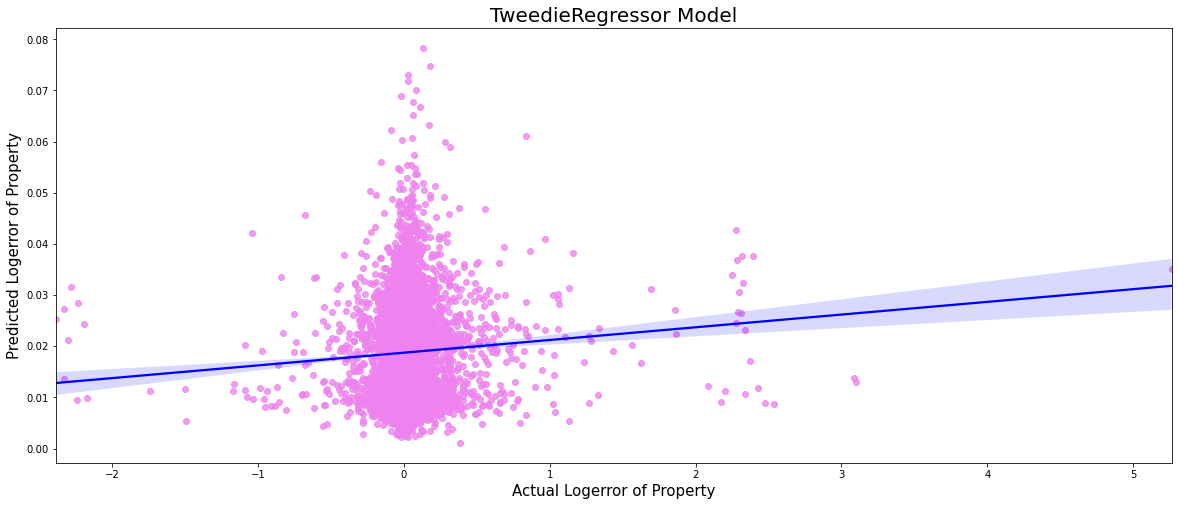

In [94]:
#looks like our TweedieRegressor did the best, let's visualize that
plt.figure(figsize=(20,8))

sns.regplot(data=y_test, x=y_validate.logerror, y=y_validate.logerror_pred_glm, 
            scatter_kws={'color':'violet'}, line_kws={'color':'blue'})
plt.xlabel("Actual Logerror of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Logerror of Property", fontdict={'fontsize':15})
plt.title("TweedieRegressor Model", fontdict={'fontsize': 20})

plt.show()

#### Testing our Tweedie Regressor Model

In [95]:
print('Baseline')
print('-----------------------------')
print('RMSE using Median\nTrain/In-Sample: ', round(rmse_train, 4), 
      '\nValidate/Out-of-Sample: ', round(rmse_validate, 4))
print('-----------------------------')

## RMSE of tax_value_pred_median train and validate scores
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 4), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

## R squared score for baseline
print('-----------------------------')
r2_baseline = r2_score(y_validate.logerror, y_validate.logerror_pred_mean)
print(f'The R squared score for the baseline is {r2_baseline}')

## predict test 
y_test['logerror_pred_glm'] = glm.predict(X_test_scaled)

rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_glm)**(1/2)
print('             ')
print('             Our Test Model')
print('-----------------------------------------')
print("RMSE for TweedieRegressor Model\nTest Performance: ", rmse_test)
r2_test_score_lm2 = r2_score(y_test.logerror, y_test.logerror_pred_glm)
print(f'TweedieRegressor Model has an R^2 value of {round(r2_test_score_lm2,4)}')


Baseline
-----------------------------
RMSE using Median
Train/In-Sample:  0.1716 
Validate/Out-of-Sample:  0.1851
-----------------------------
RMSE using Mean
Train/In-Sample:  0.1727 
Validate/Out-of-Sample:  0.1856
-----------------------------
The R squared score for the baseline is -0.00012999508777600255
             
             Our Test Model
-----------------------------------------
RMSE for TweedieRegressor Model
Test Performance:  0.16976179884211584
TweedieRegressor Model has an R^2 value of 0.0016


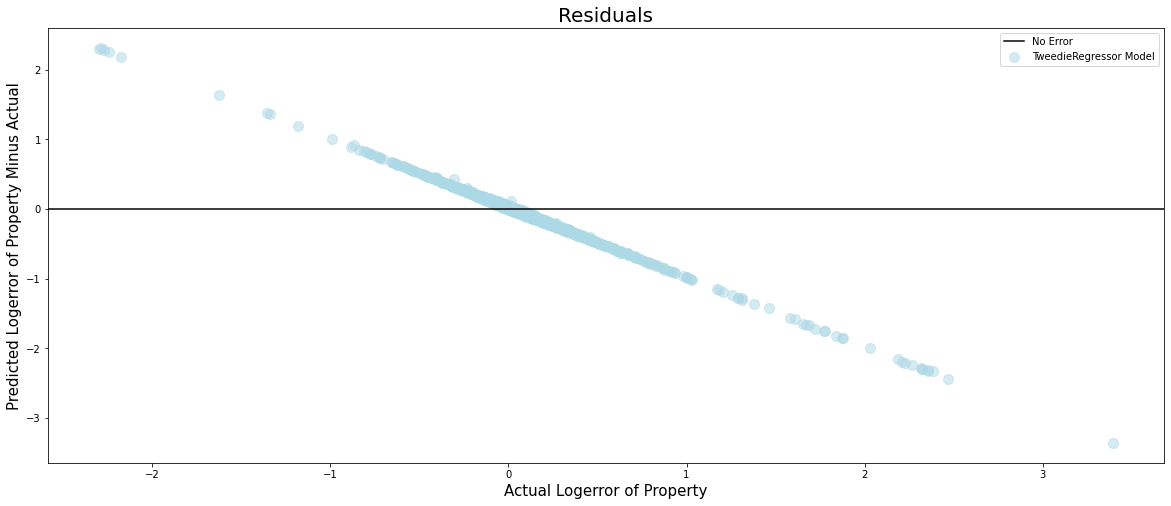

In [96]:
plt.figure(figsize=(20,8)) ## only TweedieREgressor Looking at Test
plt.axhline(label="No Error", color="black")
plt.scatter(y_test.logerror, y_test.logerror_pred_glm-y_test.logerror, 
            alpha=.5, color="lightblue", s=100, label="TweedieRegressor Model")
plt.legend()
plt.xlabel("Actual Logerror of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Logerror of Property Minus Actual", fontdict={'fontsize':15})
plt.title("Residuals", fontdict={'fontsize': 20})
plt.show()

### Conclusions & Final Takeaways

 - The Tweedie Regressor Model perforemed the best on validate and was chosen to be used on the test dataset.
 - The Tweedie Regressor Model evaluated with an RMSE of 0.16975 and an R squared value of 0.0017
 - Looking at the test residual plot we can see a grouping off closer predictions when the logerror is closer to 0 than the points further away. This may be due to other factors that were not looked into such as extensive interiors and other accessories
 - With more time I would like to look into more clusters to help improve the model and find more features to improve model performance